In [1]:
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten, Add, Conv1D, Layer
from tensorflow.keras.optimizers import RMSprop, Adam, Adadelta, Adagrad, Adamax, Ftrl, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from tensorflow_addons.metrics import F1Score
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from transformers import AutoTokenizer, TFAutoModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from tensorflow.nn import softmax as tf_softmax
import nltk
from nltk.stem import WordNetLemmatizer 
%matplotlib inline

In [2]:
!pip freeze > requirements.txt
tf.__version__

'2.6.4'

In [3]:
!nvidia-smi

Fri Mar 31 01:21:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive: ', is_interactive())

Interactive:  True


In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [6]:
special_ids = [
"sexism2022_english-2367",
"sexism2022_english-14895",
"sexism2022_english-10142",
"sexism2022_english-760",
"sexism2022_english-5370",
"sexism2022_english-10014",
"sexism2022_english-8239",
"sexism2022_english-4429",
"sexism2022_english-6149",
"sexism2022_english-5913",
"sexism2022_english-8667",
"sexism2022_english-5513",
"sexism2022_english-18585",
"sexism2022_english-13237",
"sexism2022_english-7027",
"sexism2022_english-4148",
"sexism2022_english-2061",
"sexism2022_english-11820",
"sexism2022_english-1633",
"sexism2022_english-1577",
"sexism2022_english-10821",
"sexism2022_english-14203",
"sexism2022_english-15105",
"sexism2022_english-456",
"sexism2022_english-17212",
"sexism2022_english-16704",
"sexism2022_english-3422",
"sexism2022_english-14798",
"sexism2022_english-5066",
"sexism2022_english-10614",
"sexism2022_english-11758",
"sexism2022_english-11217",
"sexism2022_english-17200",
"sexism2022_english-3823",
"sexism2022_english-4548",
"sexism2022_english-19418",
"sexism2022_english-3487",
"sexism2022_english-4807",
"sexism2022_english-3322",
"sexism2022_english-8402",
"sexism2022_english-4181",
"sexism2022_english-7777",
"sexism2022_english-10342",
"sexism2022_english-10191",
"sexism2022_english-12167",
"sexism2022_english-6994",
"sexism2022_english-3567",
"sexism2022_english-13774",
"sexism2022_english-18984",
"sexism2022_english-17490",
"sexism2022_english-17097",
"sexism2022_english-16020",
"sexism2022_english-2213",
"sexism2022_english-18692",
"sexism2022_english-2279",
"sexism2022_english-11060",
"sexism2022_english-14479",
"sexism2022_english-4257",
"sexism2022_english-6997",
"sexism2022_english-1502",
"sexism2022_english-14588",
"sexism2022_english-18156",
"sexism2022_english-8905",
"sexism2022_english-17094",
"sexism2022_english-2677",
"sexism2022_english-1559",
"sexism2022_english-5275",
"sexism2022_english-18843",
"sexism2022_english-13650",
"sexism2022_english-12691",
"sexism2022_english-9952",
"sexism2022_english-6904",
"sexism2022_english-16195",
"sexism2022_english-6949",
"sexism2022_english-16037",
"sexism2022_english-13429",
"sexism2022_english-3886",
"sexism2022_english-5367",
"sexism2022_english-960",
"sexism2022_english-9016",
"sexism2022_english-18946",
"sexism2022_english-19617",
"sexism2022_english-14174",
"sexism2022_english-3136",
"sexism2022_english-4704",
"sexism2022_english-10127",
"sexism2022_english-549",
"sexism2022_english-362",
"sexism2022_english-13433",
"sexism2022_english-12160",
"sexism2022_english-8445",
"sexism2022_english-4589",
"sexism2022_english-16768",
"sexism2022_english-4125",
"sexism2022_english-3124",
"sexism2022_english-1067",
"sexism2022_english-2900",
"sexism2022_english-4853",
"sexism2022_english-18204",
"sexism2022_english-19008",
"sexism2022_english-16034",
"sexism2022_english-18048",
"sexism2022_english-2340",
"sexism2022_english-6186",
"sexism2022_english-14425",
"sexism2022_english-16814",
"sexism2022_english-15479",
"sexism2022_english-1513",
"sexism2022_english-3000",
"sexism2022_english-7259",
"sexism2022_english-2721",
"sexism2022_english-1962",
"sexism2022_english-8434",
"sexism2022_english-15251",
"sexism2022_english-19072",
"sexism2022_english-12531",
"sexism2022_english-9505",
"sexism2022_english-9894",
"sexism2022_english-10119",
"sexism2022_english-16144",
"sexism2022_english-8846",
"sexism2022_english-8573",
"sexism2022_english-4444",
"sexism2022_english-15806",
"sexism2022_english-6818",
"sexism2022_english-7329",
"sexism2022_english-10208",
"sexism2022_english-8388",
"sexism2022_english-6939",
"sexism2022_english-14466",
"sexism2022_english-591",
"sexism2022_english-14948",
"sexism2022_english-8079",
"sexism2022_english-16236",
"sexism2022_english-10998",
"sexism2022_english-15937",
"sexism2022_english-5538",
"sexism2022_english-7260",
"sexism2022_english-17023",
"sexism2022_english-14716",
"sexism2022_english-6667",
"sexism2022_english-6436",
"sexism2022_english-12767",
"sexism2022_english-11475",
"sexism2022_english-9726",
"sexism2022_english-15520",
"sexism2022_english-15204",
"sexism2022_english-2146",
"sexism2022_english-2745",
"sexism2022_english-16746",
"sexism2022_english-14966",
"sexism2022_english-19495",
"sexism2022_english-1117",
"sexism2022_english-13473",
"sexism2022_english-6920",
"sexism2022_english-16343",
"sexism2022_english-10120",
"sexism2022_english-6171",
"sexism2022_english-18904",
"sexism2022_english-4314",
"sexism2022_english-2849",
"sexism2022_english-15595",
"sexism2022_english-19993",
"sexism2022_english-6423",
"sexism2022_english-14290",
"sexism2022_english-4283",
"sexism2022_english-13897",
"sexism2022_english-16185",
"sexism2022_english-5291",
"sexism2022_english-6886",
"sexism2022_english-4486",
"sexism2022_english-12503",
"sexism2022_english-4084",
"sexism2022_english-2629",
"sexism2022_english-4322",
"sexism2022_english-3001",
"sexism2022_english-12574",
"sexism2022_english-11279",
"sexism2022_english-13688",
"sexism2022_english-10233",
"sexism2022_english-7222",
"sexism2022_english-9007",
"sexism2022_english-17965",
"sexism2022_english-13174",
"sexism2022_english-9785",
"sexism2022_english-8037",
"sexism2022_english-12488",
"sexism2022_english-2013",
"sexism2022_english-716",
"sexism2022_english-9286",
"sexism2022_english-8183",
"sexism2022_english-14569",
"sexism2022_english-17263",
"sexism2022_english-7723",
"sexism2022_english-11675",
"sexism2022_english-6584",
"sexism2022_english-14645",
"sexism2022_english-15697",
"sexism2022_english-18248",
"sexism2022_english-9292",
"sexism2022_english-15402",
"sexism2022_english-18538",
"sexism2022_english-10571",
"sexism2022_english-13117",
"sexism2022_english-800",
"sexism2022_english-6559",
"sexism2022_english-13269",
"sexism2022_english-18573",
"sexism2022_english-11797",
"sexism2022_english-7387",
"sexism2022_english-715",
"sexism2022_english-10128",
"sexism2022_english-2906",
"sexism2022_english-16555",
"sexism2022_english-10429",
"sexism2022_english-11290",
"sexism2022_english-15609",
"sexism2022_english-10280",
"sexism2022_english-15455",
"sexism2022_english-19801",
"sexism2022_english-3193",
"sexism2022_english-997",
"sexism2022_english-12356",
"sexism2022_english-16854",
"sexism2022_english-13771",
"sexism2022_english-13447",
"sexism2022_english-16901",
"sexism2022_english-9704",
"sexism2022_english-8578",
"sexism2022_english-812",
"sexism2022_english-6343",
"sexism2022_english-11452",
"sexism2022_english-5225",
"sexism2022_english-6247",
"sexism2022_english-14110",
"sexism2022_english-7558",
"sexism2022_english-16743",
"sexism2022_english-1255",
"sexism2022_english-14104",
"sexism2022_english-7205",
"sexism2022_english-6485",
"sexism2022_english-15608",
"sexism2022_english-19399",
"sexism2022_english-17977",
"sexism2022_english-10635",
"sexism2022_english-11871",
"sexism2022_english-19214",
"sexism2022_english-9270",
"sexism2022_english-17380",
"sexism2022_english-11448",
"sexism2022_english-18743",
"sexism2022_english-5770",
"sexism2022_english-15133",
"sexism2022_english-17747",
"sexism2022_english-2427",
"sexism2022_english-4610",
"sexism2022_english-1738",
"sexism2022_english-17607",
"sexism2022_english-13206",
"sexism2022_english-8395",
"sexism2022_english-5136",
"sexism2022_english-5853",
"sexism2022_english-15738",
"sexism2022_english-2930",
"sexism2022_english-15589",
"sexism2022_english-9099",
"sexism2022_english-4506",
"sexism2022_english-11712",
"sexism2022_english-9458",
"sexism2022_english-7840",
"sexism2022_english-13717",
"sexism2022_english-2520",
"sexism2022_english-4049",
"sexism2022_english-16965",
"sexism2022_english-2353",
"sexism2022_english-17401",
"sexism2022_english-10059",
"sexism2022_english-2214",
"sexism2022_english-18006",
"sexism2022_english-337",
"sexism2022_english-6230",
"sexism2022_english-1377",
"sexism2022_english-19222",
"sexism2022_english-12214",
"sexism2022_english-12179",
"sexism2022_english-10803",
"sexism2022_english-6268",
"sexism2022_english-17143",
"sexism2022_english-2203",
"sexism2022_english-1191",
"sexism2022_english-1604",
"sexism2022_english-4609",
"sexism2022_english-8040",
"sexism2022_english-259",
"sexism2022_english-13803",
"sexism2022_english-4421",
"sexism2022_english-15886",
"sexism2022_english-14587",
"sexism2022_english-12965",
"sexism2022_english-12538",
"sexism2022_english-12607",
"sexism2022_english-14876",
"sexism2022_english-914",
"sexism2022_english-10453",
"sexism2022_english-3831",
"sexism2022_english-19974",
"sexism2022_english-11298",
"sexism2022_english-8176",
"sexism2022_english-14101",
"sexism2022_english-9737",
"sexism2022_english-18560",
"sexism2022_english-19403",
"sexism2022_english-11253",
"sexism2022_english-19066",
"sexism2022_english-17199",
"sexism2022_english-18656",
"sexism2022_english-4731",
"sexism2022_english-16499",
"sexism2022_english-2771",
"sexism2022_english-12269",
"sexism2022_english-15600",
"sexism2022_english-5556",
"sexism2022_english-15758",
"sexism2022_english-906",
"sexism2022_english-18596",
"sexism2022_english-17393",
"sexism2022_english-4653",
"sexism2022_english-18449",
"sexism2022_english-501",
"sexism2022_english-15060",
"sexism2022_english-19220",
"sexism2022_english-19370",
"sexism2022_english-3252",
"sexism2022_english-5962",
"sexism2022_english-2257",
"sexism2022_english-17811",
"sexism2022_english-4595",
"sexism2022_english-265",
"sexism2022_english-13072",
"sexism2022_english-12838",
"sexism2022_english-10164",
"sexism2022_english-13320",
"sexism2022_english-5119",
"sexism2022_english-3956",
"sexism2022_english-5964",
"sexism2022_english-19427",
"sexism2022_english-16558",
"sexism2022_english-2331",
"sexism2022_english-15446",
"sexism2022_english-11262",
"sexism2022_english-4253",
"sexism2022_english-18284",
"sexism2022_english-14627",
"sexism2022_english-15148",
"sexism2022_english-16800",
"sexism2022_english-9180",
"sexism2022_english-11705",
"sexism2022_english-19123",
"sexism2022_english-6200",
"sexism2022_english-9502",
"sexism2022_english-7617",
"sexism2022_english-19208",
"sexism2022_english-17336",
"sexism2022_english-13992",
"sexism2022_english-17002",
"sexism2022_english-2168",
"sexism2022_english-15741",
"sexism2022_english-5021",
"sexism2022_english-15036",
"sexism2022_english-13292",
"sexism2022_english-11968",
"sexism2022_english-11150",
"sexism2022_english-554",
"sexism2022_english-14475",
"sexism2022_english-16653",
"sexism2022_english-13465",
"sexism2022_english-1013",
"sexism2022_english-19750",
"sexism2022_english-19363",
"sexism2022_english-9897",
"sexism2022_english-3526",
"sexism2022_english-8866",
"sexism2022_english-13138",
"sexism2022_english-8776",
"sexism2022_english-9655",
"sexism2022_english-38",
"sexism2022_english-13856",
"sexism2022_english-3003",
"sexism2022_english-18072",
"sexism2022_english-14048",
"sexism2022_english-2087",
"sexism2022_english-11184",
"sexism2022_english-35",
"sexism2022_english-6109",
"sexism2022_english-5074",
"sexism2022_english-4359",
"sexism2022_english-12054",
"sexism2022_english-18222",
"sexism2022_english-19571",
"sexism2022_english-3381",
"sexism2022_english-9271",
"sexism2022_english-16719",
"sexism2022_english-8593",
"sexism2022_english-15117",
"sexism2022_english-16908",
"sexism2022_english-19321",
"sexism2022_english-8341",
"sexism2022_english-12333",
"sexism2022_english-17704",
"sexism2022_english-2189",
"sexism2022_english-1202",
"sexism2022_english-10722",
"sexism2022_english-11272",
"sexism2022_english-16597",
"sexism2022_english-13747",
"sexism2022_english-1462",
"sexism2022_english-19460",
"sexism2022_english-15475",
"sexism2022_english-14807",
"sexism2022_english-1468",
"sexism2022_english-1742",
"sexism2022_english-10517",
"sexism2022_english-0",
"sexism2022_english-12184",
"sexism2022_english-8632",
"sexism2022_english-17775",
"sexism2022_english-16783",
"sexism2022_english-8058",
"sexism2022_english-177",
"sexism2022_english-6419",
"sexism2022_english-17044",
"sexism2022_english-8807",
"sexism2022_english-6542",
"sexism2022_english-4654",
"sexism2022_english-19605",
"sexism2022_english-11868",
"sexism2022_english-10473",
"sexism2022_english-1876",
"sexism2022_english-17233",
"sexism2022_english-16695",
"sexism2022_english-609",
"sexism2022_english-6235",
"sexism2022_english-7407",
"sexism2022_english-5996",
"sexism2022_english-5311",
"sexism2022_english-18792",
"sexism2022_english-1371",
"sexism2022_english-8917",
"sexism2022_english-11210",
"sexism2022_english-11553",
"sexism2022_english-1735",
"sexism2022_english-123",
"sexism2022_english-14153",
"sexism2022_english-4218",
"sexism2022_english-2182",
"sexism2022_english-10250",
"sexism2022_english-447",
"sexism2022_english-6176",
"sexism2022_english-4613",
"sexism2022_english-14774",
"sexism2022_english-15467",
"sexism2022_english-15763",
"sexism2022_english-12954",
"sexism2022_english-11014",
"sexism2022_english-8569",
"sexism2022_english-14787",
"sexism2022_english-6532",
"sexism2022_english-3749",
"sexism2022_english-14198",
"sexism2022_english-16310",
"sexism2022_english-8473",
"sexism2022_english-14227",
"sexism2022_english-2178",
"sexism2022_english-1681",
"sexism2022_english-3873",
"sexism2022_english-17587",
"sexism2022_english-12780",
"sexism2022_english-3633",
"sexism2022_english-1811",
"sexism2022_english-7653",
"sexism2022_english-706",
"sexism2022_english-19465",
"sexism2022_english-13668",
"sexism2022_english-17297",
"sexism2022_english-18551",
"sexism2022_english-4894",
"sexism2022_english-18833",
"sexism2022_english-17070",
"sexism2022_english-14670",
"sexism2022_english-17589",
"sexism2022_english-13996",
"sexism2022_english-17601",
"sexism2022_english-4592",
"sexism2022_english-18762",
"sexism2022_english-1968",
"sexism2022_english-1714",
"sexism2022_english-16408",
"sexism2022_english-7351",
"sexism2022_english-3599",
"sexism2022_english-6931",
"sexism2022_english-3795",
"sexism2022_english-14027",
"sexism2022_english-1184",
"sexism2022_english-3839",
"sexism2022_english-13361",
"sexism2022_english-9944",
"sexism2022_english-6981",
"sexism2022_english-2619",
"sexism2022_english-5935",
"sexism2022_english-13564",
"sexism2022_english-7267",
"sexism2022_english-13904",
"sexism2022_english-10497",
"sexism2022_english-1023",
"sexism2022_english-4892",
"sexism2022_english-6643",
"sexism2022_english-1642",
"sexism2022_english-6026",
"sexism2022_english-18532",
"sexism2022_english-1198",
"sexism2022_english-12506",
"sexism2022_english-4835",
"sexism2022_english-10533",
"sexism2022_english-4648",
"sexism2022_english-13553",
"sexism2022_english-10226",
"sexism2022_english-10895",
"sexism2022_english-11370",
"sexism2022_english-8802",
"sexism2022_english-16797",
"sexism2022_english-11148",
"sexism2022_english-160",
"sexism2022_english-19473",
"sexism2022_english-19522",
"sexism2022_english-11512",
"sexism2022_english-6159",
"sexism2022_english-1594",
"sexism2022_english-3437",
"sexism2022_english-7400",
"sexism2022_english-3407",
"sexism2022_english-1452",
"sexism2022_english-11856",
"sexism2022_english-6308",
"sexism2022_english-14085",
"sexism2022_english-6434",
"sexism2022_english-18650",
"sexism2022_english-11558",
"sexism2022_english-72",
"sexism2022_english-9425",
"sexism2022_english-5918",
"sexism2022_english-258",
"sexism2022_english-12191",
"sexism2022_english-1141",
"sexism2022_english-1374",
"sexism2022_english-10631",
"sexism2022_english-12724",
"sexism2022_english-15907",
"sexism2022_english-4200",
"sexism2022_english-15337",
"sexism2022_english-2031",
"sexism2022_english-19683",
"sexism2022_english-19813",
"sexism2022_english-18708",
"sexism2022_english-6456",
"sexism2022_english-1218",
"sexism2022_english-16190",
"sexism2022_english-13266",
"sexism2022_english-16636",
"sexism2022_english-916",
"sexism2022_english-5139",
"sexism2022_english-12620",
"sexism2022_english-5011",
"sexism2022_english-6881",
"sexism2022_english-2323",
"sexism2022_english-14933",
"sexism2022_english-8657",
"sexism2022_english-13964",
"sexism2022_english-12853",
"sexism2022_english-5149",
"sexism2022_english-5346",
"sexism2022_english-7716",
"sexism2022_english-10889",
"sexism2022_english-16810",
"sexism2022_english-7055",
"sexism2022_english-13020",
"sexism2022_english-14352",
"sexism2022_english-419",
"sexism2022_english-11489",
"sexism2022_english-14744",
"sexism2022_english-18207",
"sexism2022_english-9598",
"sexism2022_english-19623",
"sexism2022_english-12655",
"sexism2022_english-15483",
"sexism2022_english-18519",
"sexism2022_english-9422",
"sexism2022_english-8851",
"sexism2022_english-10368",
"sexism2022_english-18443",
"sexism2022_english-10935",
"sexism2022_english-18112",
"sexism2022_english-18349",
"sexism2022_english-19564",
"sexism2022_english-11001",
"sexism2022_english-9965",
"sexism2022_english-19290",
"sexism2022_english-11850",
"sexism2022_english-19263",
"sexism2022_english-12647",
"sexism2022_english-17717",
"sexism2022_english-4943",
"sexism2022_english-11153",
"sexism2022_english-3261",
"sexism2022_english-13235",
"sexism2022_english-15774",
"sexism2022_english-15923",
"sexism2022_english-11807",
"sexism2022_english-19143",
"sexism2022_english-921",
"sexism2022_english-19022",
"sexism2022_english-4745",
"sexism2022_english-18782",
"sexism2022_english-7399",
"sexism2022_english-5288",
"sexism2022_english-6503",
"sexism2022_english-14972",
"sexism2022_english-12486",
"sexism2022_english-11750",
"sexism2022_english-16476",
"sexism2022_english-9820",
"sexism2022_english-13100",
"sexism2022_english-10125",
"sexism2022_english-2216",
"sexism2022_english-9319",
"sexism2022_english-12730",
"sexism2022_english-19314",
"sexism2022_english-7070",
"sexism2022_english-12410",
"sexism2022_english-14898",
"sexism2022_english-4945",
"sexism2022_english-3801",
"sexism2022_english-7978",
"sexism2022_english-2778",
"sexism2022_english-8467",
"sexism2022_english-9202",
"sexism2022_english-172",
"sexism2022_english-5285",
"sexism2022_english-1554",
"sexism2022_english-15860",
"sexism2022_english-9718",
"sexism2022_english-3668",
"sexism2022_english-5359",
"sexism2022_english-6346",
"sexism2022_english-6940",
"sexism2022_english-3680",
"sexism2022_english-14160",
"sexism2022_english-5125",
"sexism2022_english-5552",
"sexism2022_english-12241",
"sexism2022_english-2934",
"sexism2022_english-12863",
"sexism2022_english-12537",
"sexism2022_english-1310",
"sexism2022_english-6810",
"sexism2022_english-977",
"sexism2022_english-11363",
"sexism2022_english-1356",
"sexism2022_english-17819",
"sexism2022_english-11781",
"sexism2022_english-4047",
"sexism2022_english-17179",
"sexism2022_english-4757",
"sexism2022_english-7042",
"sexism2022_english-17206",
"sexism2022_english-14437",
"sexism2022_english-535",
"sexism2022_english-8539",
"sexism2022_english-6127",
"sexism2022_english-15890",
"sexism2022_english-5154",
"sexism2022_english-1172",
"sexism2022_english-13729",
"sexism2022_english-6622",
"sexism2022_english-3964",
"sexism2022_english-11904",
"sexism2022_english-15157",
"sexism2022_english-14546",
"sexism2022_english-6707",
"sexism2022_english-12378",
"sexism2022_english-17300",
"sexism2022_english-11650",
"sexism2022_english-3433",
"sexism2022_english-9631",
"sexism2022_english-9474",
"sexism2022_english-5665",
"sexism2022_english-11256",
"sexism2022_english-12499",
"sexism2022_english-6356",
"sexism2022_english-6927",
"sexism2022_english-12988",
"sexism2022_english-6953",
"sexism2022_english-14446",
"sexism2022_english-6263",
"sexism2022_english-18428",
"sexism2022_english-14863",
"sexism2022_english-15203",
"sexism2022_english-17432",
"sexism2022_english-15623",
"sexism2022_english-9054",
"sexism2022_english-14969",
"sexism2022_english-12124",
"sexism2022_english-13238",
"sexism2022_english-13535",
"sexism2022_english-9764",
"sexism2022_english-2990",
"sexism2022_english-3670",
"sexism2022_english-17754",
"sexism2022_english-10786",
"sexism2022_english-6910",
"sexism2022_english-10343",
"sexism2022_english-19602",
"sexism2022_english-15010",
"sexism2022_english-8735",
"sexism2022_english-7543",
"sexism2022_english-18799",
"sexism2022_english-19926",
"sexism2022_english-15493",
"sexism2022_english-15542",
"sexism2022_english-16012",
"sexism2022_english-10206",
"sexism2022_english-16220",
"sexism2022_english-911",
"sexism2022_english-4579",
"sexism2022_english-17302",
"sexism2022_english-4377",
"sexism2022_english-12028",
"sexism2022_english-9550",
"sexism2022_english-14795",
"sexism2022_english-908",
"sexism2022_english-7101",
"sexism2022_english-1788",
"sexism2022_english-14331",
"sexism2022_english-6206",
"sexism2022_english-1687",
"sexism2022_english-3631",
"sexism2022_english-9580",
"sexism2022_english-5789",
"sexism2022_english-10547",
"sexism2022_english-16551",
"sexism2022_english-10234",
"sexism2022_english-14073",
"sexism2022_english-2614",
"sexism2022_english-17292",
"sexism2022_english-5113",
"sexism2022_english-288",
"sexism2022_english-14424",
"sexism2022_english-6690",
"sexism2022_english-5581",
"sexism2022_english-9721",
"sexism2022_english-12596",
"sexism2022_english-11764",
"sexism2022_english-5176",
"sexism2022_english-8098",
"sexism2022_english-11734",
"sexism2022_english-18537",
"sexism2022_english-9449",
"sexism2022_english-18402",
"sexism2022_english-18513",
"sexism2022_english-6326",
"sexism2022_english-11432",
"sexism2022_english-7129",
"sexism2022_english-12957",
"sexism2022_english-1409",
"sexism2022_english-7790",
"sexism2022_english-7176",
"sexism2022_english-421",
"sexism2022_english-14867",
"sexism2022_english-2095",
"sexism2022_english-770",
"sexism2022_english-2776",
"sexism2022_english-16948",
"sexism2022_english-13619",
"sexism2022_english-1449",
"sexism2022_english-10772",
"sexism2022_english-2142",
"sexism2022_english-457",
"sexism2022_english-17838",
"sexism2022_english-16894",
"sexism2022_english-7542",
"sexism2022_english-9719",
"sexism2022_english-14351",
"sexism2022_english-1832",
"sexism2022_english-13231",
"sexism2022_english-14092",
"sexism2022_english-5545",
"sexism2022_english-9378",
"sexism2022_english-11817",
"sexism2022_english-12003",
"sexism2022_english-10673",
"sexism2022_english-17809",
"sexism2022_english-17504",
"sexism2022_english-7304",
"sexism2022_english-18206",
"sexism2022_english-15026",
"sexism2022_english-5558",
"sexism2022_english-15172",
"sexism2022_english-10961",
"sexism2022_english-14180",
"sexism2022_english-10815",
"sexism2022_english-7999",
"sexism2022_english-1866",
"sexism2022_english-13593",
"sexism2022_english-2610",
"sexism2022_english-6689",
"sexism2022_english-6318",
"sexism2022_english-10794",
"sexism2022_english-1453",
"sexism2022_english-8128",
"sexism2022_english-901",
"sexism2022_english-13620",
"sexism2022_english-14613",
"sexism2022_english-5258",
"sexism2022_english-19611",
"sexism2022_english-14560",
"sexism2022_english-648",
"sexism2022_english-18858",
"sexism2022_english-552",
"sexism2022_english-1022",
"sexism2022_english-16378",
"sexism2022_english-41",
"sexism2022_english-15302",
"sexism2022_english-9259",
"sexism2022_english-16356",
"sexism2022_english-1669",
"sexism2022_english-19299",
"sexism2022_english-1889",
"sexism2022_english-7880",
"sexism2022_english-12095",
"sexism2022_english-4310",
"sexism2022_english-10994",
"sexism2022_english-6225",
"sexism2022_english-16469",
"sexism2022_english-661",
"sexism2022_english-16994",
"sexism2022_english-19009",
"sexism2022_english-11954",
"sexism2022_english-5084",
"sexism2022_english-14608",
"sexism2022_english-14891",
"sexism2022_english-9994",
"sexism2022_english-11915",
"sexism2022_english-7734",
"sexism2022_english-5941",
"sexism2022_english-10073",
"sexism2022_english-10103",
"sexism2022_english-14216",
"sexism2022_english-16106",
"sexism2022_english-232",
"sexism2022_english-13454",
"sexism2022_english-15433",
"sexism2022_english-16429",
"sexism2022_english-10814",
"sexism2022_english-5489",
"sexism2022_english-19963",
"sexism2022_english-5511",
"sexism2022_english-19021",
"sexism2022_english-12753",
"sexism2022_english-3467",
"sexism2022_english-14901",
"sexism2022_english-18734",
"sexism2022_english-17835",
"sexism2022_english-5660",
"sexism2022_english-14566",
"sexism2022_english-13077",
"sexism2022_english-1806",
"sexism2022_english-13988",
"sexism2022_english-15710",
"sexism2022_english-6228",
"sexism2022_english-9302",
"sexism2022_english-13661",
"sexism2022_english-16764",
"sexism2022_english-14507",
"sexism2022_english-12716",
"sexism2022_english-9795",
"sexism2022_english-1187",
"sexism2022_english-18099",
"sexism2022_english-1373",
"sexism2022_english-483",
"sexism2022_english-1102",
"sexism2022_english-1279",
"sexism2022_english-16113",
"sexism2022_english-2525",
"sexism2022_english-9179",
"sexism2022_english-11122",
"sexism2022_english-19744",
"sexism2022_english-3905",
"sexism2022_english-9412",
"sexism2022_english-11328",
"sexism2022_english-1944",
"sexism2022_english-10970",
"sexism2022_english-2150",
"sexism2022_english-6494",
"sexism2022_english-18798",
"sexism2022_english-11283",
"sexism2022_english-14838",
"sexism2022_english-1722",
"sexism2022_english-14460",
"sexism2022_english-5215",
"sexism2022_english-13363",
"sexism2022_english-12067",
"sexism2022_english-3033",
"sexism2022_english-5168",
"sexism2022_english-17645",
"sexism2022_english-17749",
"sexism2022_english-7178",
"sexism2022_english-13202",
"sexism2022_english-7340",
"sexism2022_english-11858",
"sexism2022_english-3827",
"sexism2022_english-15982",
"sexism2022_english-9855",
"sexism2022_english-13819",
"sexism2022_english-13308",
"sexism2022_english-14788",
"sexism2022_english-15717",
"sexism2022_english-3848",
"sexism2022_english-3265",
"sexism2022_english-3510",
"sexism2022_english-4620",
"sexism2022_english-6738",
"sexism2022_english-19439",
"sexism2022_english-11957",
"sexism2022_english-4570",
"sexism2022_english-19286",
"sexism2022_english-16022",
"sexism2022_english-11720",
"sexism2022_english-9210",
"sexism2022_english-18418",
"sexism2022_english-728",
"sexism2022_english-9841",
"sexism2022_english-7475",
"sexism2022_english-4900",
"sexism2022_english-6205",
"sexism2022_english-10013",
"sexism2022_english-16700",
"sexism2022_english-17203",
"sexism2022_english-10658",
"sexism2022_english-18127",
"sexism2022_english-7391",
"sexism2022_english-13366",
"sexism2022_english-19237",
"sexism2022_english-1682",
"sexism2022_english-10088",
"sexism2022_english-3985",
"sexism2022_english-9896",
"sexism2022_english-3627",
"sexism2022_english-11227",
"sexism2022_english-4316",
"sexism2022_english-4244",
"sexism2022_english-19025",
"sexism2022_english-6280",
"sexism2022_english-8289",
"sexism2022_english-5653",
"sexism2022_english-7274",
"sexism2022_english-5388",
"sexism2022_english-9663",
"sexism2022_english-11565",
"sexism2022_english-3192",
"sexism2022_english-18273",
"sexism2022_english-6842",
"sexism2022_english-593",
"sexism2022_english-2483",
"sexism2022_english-68",
"sexism2022_english-5323",
"sexism2022_english-5429",
"sexism2022_english-1548",
"sexism2022_english-11914",
"sexism2022_english-1988",
"sexism2022_english-5662",
"sexism2022_english-15708",
"sexism2022_english-14592",
"sexism2022_english-10115",
"sexism2022_english-7983",
"sexism2022_english-5177",
"sexism2022_english-8227",
"sexism2022_english-13426",
"sexism2022_english-6946",
"sexism2022_english-10029",
"sexism2022_english-19681",
"sexism2022_english-1895",
"sexism2022_english-15210",
"sexism2022_english-19914",
"sexism2022_english-8137",
"sexism2022_english-2293",
"sexism2022_english-780",
"sexism2022_english-2391",
"sexism2022_english-711",
"sexism2022_english-1500",
"sexism2022_english-266",
"sexism2022_english-15851",
"sexism2022_english-5156",
"sexism2022_english-5353",
"sexism2022_english-7751",
"sexism2022_english-3142",
"sexism2022_english-14267",
"sexism2022_english-1113",
"sexism2022_english-1518",
"sexism2022_english-5274",
"sexism2022_english-9261",
"sexism2022_english-15196",
"sexism2022_english-19908",
"sexism2022_english-3582",
"sexism2022_english-3620",
"sexism2022_english-4245",
"sexism2022_english-8144",
"sexism2022_english-16118",
"sexism2022_english-13934",
"sexism2022_english-11641",
"sexism2022_english-12056",
"sexism2022_english-17650",
"sexism2022_english-10928",
"sexism2022_english-1176",
"sexism2022_english-2051",
"sexism2022_english-2799",
"sexism2022_english-8931",
"sexism2022_english-13993",
"sexism2022_english-15934",
"sexism2022_english-6505",
"sexism2022_english-10971",
"sexism2022_english-16319",
"sexism2022_english-2303",
"sexism2022_english-2062",
"sexism2022_english-9826",
"sexism2022_english-16760",
"sexism2022_english-3412",
"sexism2022_english-953",
"sexism2022_english-9208",
"sexism2022_english-17680",
"sexism2022_english-635",
"sexism2022_english-15064",
"sexism2022_english-16011",
"sexism2022_english-13185",
"sexism2022_english-6973",
"sexism2022_english-17774",
"sexism2022_english-14824",
"sexism2022_english-15638",
"sexism2022_english-2477",
"sexism2022_english-4056",
"sexism2022_english-15564",
"sexism2022_english-1334",
"sexism2022_english-19349",
"sexism2022_english-231",
"sexism2022_english-1776",
"sexism2022_english-10318",
"sexism2022_english-17931",
"sexism2022_english-3403",
"sexism2022_english-14228",
"sexism2022_english-824",
"sexism2022_english-19049",
"sexism2022_english-13615",
"sexism2022_english-4300",
"sexism2022_english-16201",
"sexism2022_english-19467",
"sexism2022_english-8827",
"sexism2022_english-8571",
"sexism2022_english-19656",
"sexism2022_english-16288",
"sexism2022_english-18682",
"sexism2022_english-1899",
"sexism2022_english-15034",
"sexism2022_english-16640",
"sexism2022_english-15004",
"sexism2022_english-4643",
"sexism2022_english-9868",
"sexism2022_english-17371",
"sexism2022_english-18801",
"sexism2022_english-18065",
"sexism2022_english-746",
"sexism2022_english-1580",
"sexism2022_english-7855",
"sexism2022_english-3954",
"sexism2022_english-6417",
"sexism2022_english-1782",
"sexism2022_english-12097",
"sexism2022_english-3877",
"sexism2022_english-8959",
"sexism2022_english-6853",
"sexism2022_english-6849",
"sexism2022_english-5892",
"sexism2022_english-3754",
"sexism2022_english-14751",
"sexism2022_english-4392",
"sexism2022_english-8299",
"sexism2022_english-5969",
"sexism2022_english-3737",
"sexism2022_english-13804",
"sexism2022_english-14397",
"sexism2022_english-16627",
"sexism2022_english-13482",
"sexism2022_english-15574",
"sexism2022_english-15066",
"sexism2022_english-16502",
"sexism2022_english-13651",
"sexism2022_english-17389",
"sexism2022_english-19188",
"sexism2022_english-5792",
"sexism2022_english-7183",
"sexism2022_english-9042",
"sexism2022_english-13221",
"sexism2022_english-5086",
"sexism2022_english-12278",
"sexism2022_english-1673",
"sexism2022_english-17999",
"sexism2022_english-15488",
"sexism2022_english-19212",
"sexism2022_english-16752",
"sexism2022_english-3139",
"sexism2022_english-8548",
"sexism2022_english-17332",
"sexism2022_english-10502",
"sexism2022_english-2988",
"sexism2022_english-13058",
"sexism2022_english-15396",
"sexism2022_english-19386",
"sexism2022_english-4278",
"sexism2022_english-8159",
"sexism2022_english-11387",
"sexism2022_english-149",
"sexism2022_english-1809",
"sexism2022_english-2441",
"sexism2022_english-9708",
"sexism2022_english-6208",
"sexism2022_english-18787",
"sexism2022_english-8153",
"sexism2022_english-10506",
"sexism2022_english-9610",
"sexism2022_english-18935",
"sexism2022_english-1396",
"sexism2022_english-14265",
"sexism2022_english-9265",
"sexism2022_english-17687",
"sexism2022_english-16871",
"sexism2022_english-5900",
"sexism2022_english-6189",
"sexism2022_english-2867",
"sexism2022_english-11293",
"sexism2022_english-3718",
"sexism2022_english-13056",
"sexism2022_english-15145",
"sexism2022_english-14036",
"sexism2022_english-10076",
"sexism2022_english-14693",
"sexism2022_english-1193",
"sexism2022_english-15377",
"sexism2022_english-12687",
"sexism2022_english-10414",
"sexism2022_english-17229",
"sexism2022_english-13214",
"sexism2022_english-17431",
"sexism2022_english-15021",
"sexism2022_english-6664",
"sexism2022_english-18926",
"sexism2022_english-12145",
"sexism2022_english-2472",
"sexism2022_english-9394",
"sexism2022_english-13456",
"sexism2022_english-7900",
"sexism2022_english-12472",
"sexism2022_english-9717",
"sexism2022_english-10955",
"sexism2022_english-14547",
"sexism2022_english-4959",
"sexism2022_english-2153",
"sexism2022_english-10298",
"sexism2022_english-8283",
"sexism2022_english-4895",
"sexism2022_english-11303",
"sexism2022_english-12934",
"sexism2022_english-6533",
"sexism2022_english-12189",
"sexism2022_english-166",
"sexism2022_english-7829",
"sexism2022_english-1399",
"sexism2022_english-18554",
"sexism2022_english-15751",
"sexism2022_english-18736",
"sexism2022_english-14225",
"sexism2022_english-8609",
"sexism2022_english-15538",
"sexism2022_english-12727",
"sexism2022_english-12338",
"sexism2022_english-7992",
"sexism2022_english-15690",
"sexism2022_english-12871",
"sexism2022_english-526",
"sexism2022_english-5423",
"sexism2022_english-1231",
"sexism2022_english-11564",
"sexism2022_english-4454",
"sexism2022_english-2995",
"sexism2022_english-18699",
"sexism2022_english-9590",
"sexism2022_english-19297",
"sexism2022_english-6267",
"sexism2022_english-18093",
"sexism2022_english-1820",
"sexism2022_english-9006",
"sexism2022_english-11299",
"sexism2022_english-1165",
"sexism2022_english-16084",
"sexism2022_english-18590",
"sexism2022_english-6150",
"sexism2022_english-9351",
"sexism2022_english-14865",
"sexism2022_english-12319",
"sexism2022_english-6856",
"sexism2022_english-17290",
"sexism2022_english-6141",
"sexism2022_english-19283",
"sexism2022_english-8446",
"sexism2022_english-9799",
"sexism2022_english-12927",
"sexism2022_english-5530",
"sexism2022_english-14142",
"sexism2022_english-9184",
"sexism2022_english-14365",
"sexism2022_english-13706",
"sexism2022_english-5813",
"sexism2022_english-18220",
"sexism2022_english-6218",
"sexism2022_english-18863",
"sexism2022_english-14343",
"sexism2022_english-13683",
"sexism2022_english-12190",
"sexism2022_english-6375",
"sexism2022_english-13741",
"sexism2022_english-3150",
"sexism2022_english-215",
"sexism2022_english-19680",
"sexism2022_english-413",
"sexism2022_english-19007",
"sexism2022_english-5785",
"sexism2022_english-17162",
"sexism2022_english-8831",
"sexism2022_english-13493",
"sexism2022_english-7595",
"sexism2022_english-12080",
"sexism2022_english-2065",
"sexism2022_english-13737",
"sexism2022_english-5509",
"sexism2022_english-13511",
"sexism2022_english-12977",
"sexism2022_english-1578",
"sexism2022_english-7068",
"sexism2022_english-18255",
"sexism2022_english-1831",
"sexism2022_english-4840",
"sexism2022_english-6154",
"sexism2022_english-19883",
"sexism2022_english-13498",
"sexism2022_english-18377",
"sexism2022_english-19265",
"sexism2022_english-3525",
"sexism2022_english-15179",
"sexism2022_english-10134",
"sexism2022_english-14931",
"sexism2022_english-5619",
"sexism2022_english-281",
"sexism2022_english-5586",
"sexism2022_english-2646",
"sexism2022_english-13914",
"sexism2022_english-584",
"sexism2022_english-8742",
"sexism2022_english-13637",
"sexism2022_english-18492",
"sexism2022_english-10789",
"sexism2022_english-13234",
"sexism2022_english-2049",
"sexism2022_english-4646",
"sexism2022_english-8358",
"sexism2022_english-17891",
"sexism2022_english-12027",
"sexism2022_english-12589",
"sexism2022_english-5404",
"sexism2022_english-17890",
"sexism2022_english-2373",
"sexism2022_english-19400",
"sexism2022_english-9677",
"sexism2022_english-10291",
"sexism2022_english-10044",
"sexism2022_english-3112",
"sexism2022_english-4559",
"sexism2022_english-13923",
"sexism2022_english-18137",
"sexism2022_english-12810",
"sexism2022_english-13826",
"sexism2022_english-3912",
"sexism2022_english-7497",
"sexism2022_english-1190",
"sexism2022_english-3007",
"sexism2022_english-1629",
"sexism2022_english-12205",
"sexism2022_english-16849",
"sexism2022_english-16805",
"sexism2022_english-13968",
"sexism2022_english-125",
"sexism2022_english-19463",
"sexism2022_english-19052",
"sexism2022_english-1010",
"sexism2022_english-8789",
"sexism2022_english-2561",
"sexism2022_english-9878",
"sexism2022_english-17295",
"sexism2022_english-11934",
"sexism2022_english-14785",
"sexism2022_english-10944",
"sexism2022_english-7874",
"sexism2022_english-11595",
"sexism2022_english-7410",
"sexism2022_english-33",
"sexism2022_english-322",
"sexism2022_english-458",
"sexism2022_english-12644",
"sexism2022_english-4697",
"sexism2022_english-19964",
"sexism2022_english-6029",
"sexism2022_english-4755",
"sexism2022_english-13183",
"sexism2022_english-10228",
"sexism2022_english-109",
"sexism2022_english-12330",
"sexism2022_english-17118",
"sexism2022_english-14134",
"sexism2022_english-444",
"sexism2022_english-14859",
"sexism2022_english-2204",
"sexism2022_english-768",
"sexism2022_english-9527",
"sexism2022_english-14354",
"sexism2022_english-6475",
"sexism2022_english-5815",
"sexism2022_english-17083",
"sexism2022_english-11240",
"sexism2022_english-16041",
"sexism2022_english-11952",
"sexism2022_english-17491",
"sexism2022_english-3770",
"sexism2022_english-11879",
"sexism2022_english-1275",
"sexism2022_english-3782",
"sexism2022_english-17305",
"sexism2022_english-15262",
"sexism2022_english-8710",
"sexism2022_english-5147",
"sexism2022_english-4235",
"sexism2022_english-2351",
"sexism2022_english-13079",
"sexism2022_english-5754",
"sexism2022_english-6160",
"sexism2022_english-16754",
"sexism2022_english-14304",
"sexism2022_english-3078",
"sexism2022_english-2252",
"sexism2022_english-6800",
"sexism2022_english-2449",
"sexism2022_english-7011",
"sexism2022_english-7331",
"sexism2022_english-272",
"sexism2022_english-18464",
"sexism2022_english-18550",
"sexism2022_english-14672",
"sexism2022_english-8531",
"sexism2022_english-1153",
"sexism2022_english-16165",
"sexism2022_english-19535",
"sexism2022_english-4102",
"sexism2022_english-16216",
"sexism2022_english-13761",
"sexism2022_english-5320",
"sexism2022_english-5677",
"sexism2022_english-10564",
"sexism2022_english-6925",
"sexism2022_english-7022",
"sexism2022_english-9557",
"sexism2022_english-19016",
"sexism2022_english-9574",
"sexism2022_english-17815",
"sexism2022_english-2275",
"sexism2022_english-3196",
"sexism2022_english-19039",
"sexism2022_english-12653",
"sexism2022_english-2388",
"sexism2022_english-8488",
"sexism2022_english-13796",
"sexism2022_english-3972",
"sexism2022_english-11575",
"sexism2022_english-3943",
"sexism2022_english-19939",
"sexism2022_english-5387",
"sexism2022_english-7508",
"sexism2022_english-3313",
"sexism2022_english-310",
"sexism2022_english-16043",
"sexism2022_english-13939",
"sexism2022_english-4185",
"sexism2022_english-12629",
"sexism2022_english-15329",
"sexism2022_english-14924",
"sexism2022_english-1166",
"sexism2022_english-18772",
"sexism2022_english-6678",
"sexism2022_english-14415",
"sexism2022_english-9594",
"sexism2022_english-3898",
"sexism2022_english-2262",
"sexism2022_english-6414",
"sexism2022_english-1838",
"sexism2022_english-1254",
"sexism2022_english-4790",
"sexism2022_english-10511",
"sexism2022_english-1721",
"sexism2022_english-19483",
"sexism2022_english-6806",
"sexism2022_english-17824",
"sexism2022_english-12683",
"sexism2022_english-2855",
"sexism2022_english-2424",
"sexism2022_english-8429",
"sexism2022_english-15280",
"sexism2022_english-14625",
"sexism2022_english-18691",
"sexism2022_english-13125",
"sexism2022_english-4210",
"sexism2022_english-10864",
"sexism2022_english-2077",
"sexism2022_english-9023",
"sexism2022_english-4466",
"sexism2022_english-211",
"sexism2022_english-13542",
"sexism2022_english-16592",
"sexism2022_english-77",
"sexism2022_english-18894",
"sexism2022_english-438",
"sexism2022_english-6612",
"sexism2022_english-9980",
"sexism2022_english-17939",
"sexism2022_english-6813",
"sexism2022_english-2094",
"sexism2022_english-7269",
"sexism2022_english-12497",
"sexism2022_english-18417",
"sexism2022_english-19171",
"sexism2022_english-2594",
"sexism2022_english-13249",
"sexism2022_english-2961",
"sexism2022_english-10384",
"sexism2022_english-17831",
"sexism2022_english-15092",
"sexism2022_english-7389",
"sexism2022_english-2642",
"sexism2022_english-6979",
"sexism2022_english-6982",
"sexism2022_english-3028",
"sexism2022_english-19014",
"sexism2022_english-13778",
"sexism2022_english-18849",
"sexism2022_english-11100",
"sexism2022_english-12602",
"sexism2022_english-17964",
"sexism2022_english-2723",
"sexism2022_english-4647",
"sexism2022_english-17008",
"sexism2022_english-18477",
"sexism2022_english-9757",
"sexism2022_english-12866",
"sexism2022_english-17009",
"sexism2022_english-12524",
"sexism2022_english-7817",
"sexism2022_english-13561",
"sexism2022_english-9249",
"sexism2022_english-14084",
"sexism2022_english-12648",
"sexism2022_english-4582",
"sexism2022_english-2365",
"sexism2022_english-15125",
"sexism2022_english-5244",
"sexism2022_english-12811",
"sexism2022_english-1189",
"sexism2022_english-5659",
"sexism2022_english-12037",
"sexism2022_english-3397",
"sexism2022_english-11900",
"sexism2022_english-12113",
"sexism2022_english-16513",
"sexism2022_english-4330",
"sexism2022_english-12384",
"sexism2022_english-14163",
"sexism2022_english-15052",
"sexism2022_english-3360",
"sexism2022_english-4112",
"sexism2022_english-7608",
"sexism2022_english-2399",
"sexism2022_english-18724",
"sexism2022_english-2467",
"sexism2022_english-18270",
"sexism2022_english-12523",
"sexism2022_english-15122",
"sexism2022_english-899",
"sexism2022_english-13094",
"sexism2022_english-10417",
"sexism2022_english-5265",
"sexism2022_english-8638",
"sexism2022_english-1857",
"sexism2022_english-4775",
"sexism2022_english-13071",
"sexism2022_english-4483",
"sexism2022_english-18711",
"sexism2022_english-851",
"sexism2022_english-11715",
"sexism2022_english-15797",
"sexism2022_english-14251",
"sexism2022_english-1952",
"sexism2022_english-8246",
"sexism2022_english-17619",
"sexism2022_english-943",
"sexism2022_english-2943",
"sexism2022_english-16847",
"sexism2022_english-12164",
"sexism2022_english-18153",
"sexism2022_english-11867",
"sexism2022_english-2092",
"sexism2022_english-6496",
"sexism2022_english-3137",
"sexism2022_english-8830",
"sexism2022_english-910",
"sexism2022_english-9304",
"sexism2022_english-6778",
"sexism2022_english-7546",
"sexism2022_english-9759",
"sexism2022_english-6227",
"sexism2022_english-9134",
"sexism2022_english-7895",
"sexism2022_english-11528",
"sexism2022_english-5986",
"sexism2022_english-15605",
"sexism2022_english-12116",
"sexism2022_english-16537",
"sexism2022_english-5026",
"sexism2022_english-6035",
"sexism2022_english-2428",
"sexism2022_english-14277",
"sexism2022_english-4779",
"sexism2022_english-18535",
"sexism2022_english-1585",
"sexism2022_english-16391",
"sexism2022_english-12610",
"sexism2022_english-12846",
"sexism2022_english-3428",
"sexism2022_english-3671",
"sexism2022_english-18533",
"sexism2022_english-4638",
"sexism2022_english-13664",
"sexism2022_english-17218",
"sexism2022_english-2697",
"sexism2022_english-10159",
"sexism2022_english-9546",
"sexism2022_english-17355",
"sexism2022_english-14177",
"sexism2022_english-3418",
"sexism2022_english-7530",
"sexism2022_english-16745",
"sexism2022_english-11726",
"sexism2022_english-7292",
"sexism2022_english-15375",
"sexism2022_english-14062",
"sexism2022_english-10052",
"sexism2022_english-16569",
"sexism2022_english-3432",
"sexism2022_english-999",
"sexism2022_english-14419",
"sexism2022_english-14848",
"sexism2022_english-4079",
"sexism2022_english-12613",
"sexism2022_english-13441",
"sexism2022_english-18034",
"sexism2022_english-405",
"sexism2022_english-15973",
"sexism2022_english-11320",
"sexism2022_english-2243",
"sexism2022_english-12301",
"sexism2022_english-3864",
"sexism2022_english-12083",
"sexism2022_english-1204",
"sexism2022_english-4805",
"sexism2022_english-17310",
"sexism2022_english-14558",
"sexism2022_english-18238",
"sexism2022_english-14816",
"sexism2022_english-254",
"sexism2022_english-13670",
"sexism2022_english-6021",
"sexism2022_english-4857",
"sexism2022_english-1756",
"sexism2022_english-7228",
"sexism2022_english-9816",
"sexism2022_english-5",
"sexism2022_english-4860",
"sexism2022_english-11411",
"sexism2022_english-4145",
"sexism2022_english-2742",
"sexism2022_english-13495",
"sexism2022_english-7033",
"sexism2022_english-10411",
"sexism2022_english-4925",
"sexism2022_english-9629",
"sexism2022_english-11508",
"sexism2022_english-451",
"sexism2022_english-17658",
"sexism2022_english-1483",
"sexism2022_english-5377",
"sexism2022_english-2029",
"sexism2022_english-2544",
"sexism2022_english-11690",
"sexism2022_english-10844",
"sexism2022_english-2421",
"sexism2022_english-1707",
"sexism2022_english-9263",
"sexism2022_english-8616",
"sexism2022_english-5219",
"sexism2022_english-14827",
"sexism2022_english-2010",
"sexism2022_english-12686",
"sexism2022_english-1849",
"sexism2022_english-89",
"sexism2022_english-15649",
"sexism2022_english-1852",
"sexism2022_english-15031",
"sexism2022_english-12007",
"sexism2022_english-5645",
"sexism2022_english-6285",
"sexism2022_english-12363",
"sexism2022_english-13430",
"sexism2022_english-1877",
"sexism2022_english-2669",
"sexism2022_english-18245",
"sexism2022_english-10579",
"sexism2022_english-6202",
"sexism2022_english-1640",
"sexism2022_english-18883",
"sexism2022_english-11907",
"sexism2022_english-12669",
"sexism2022_english-14890",
"sexism2022_english-8872",
"sexism2022_english-10720",
"sexism2022_english-8200",
"sexism2022_english-7779",
"sexism2022_english-18868",
"sexism2022_english-9127",
"sexism2022_english-19551",
"sexism2022_english-11674",
"sexism2022_english-4263",
"sexism2022_english-1002",
"sexism2022_english-3478",
"sexism2022_english-6600",
"sexism2022_english-10827",
"sexism2022_english-16108",
"sexism2022_english-2744",
"sexism2022_english-3573",
"sexism2022_english-7472",
"sexism2022_english-18990",
"sexism2022_english-14427",
"sexism2022_english-7585",
"sexism2022_english-8323",
"sexism2022_english-16790",
"sexism2022_english-16899",
"sexism2022_english-14721",
"sexism2022_english-3942",
"sexism2022_english-13790",
"sexism2022_english-4281",
"sexism2022_english-3870",
"sexism2022_english-1631",
"sexism2022_english-3785",
"sexism2022_english-11158",
"sexism2022_english-12621",
"sexism2022_english-345",
"sexism2022_english-17941",
"sexism2022_english-8761",
"sexism2022_english-2938",
"sexism2022_english-10163",
"sexism2022_english-6195",
"sexism2022_english-4885",
"sexism2022_english-1612",
"sexism2022_english-17049",
"sexism2022_english-16940",
"sexism2022_english-811",
"sexism2022_english-11994",
"sexism2022_english-4531",
"sexism2022_english-17185",
"sexism2022_english-12743",
"sexism2022_english-8002",
"sexism2022_english-8385",
"sexism2022_english-9157",
"sexism2022_english-7393",
"sexism2022_english-406",
"sexism2022_english-2014",
"sexism2022_english-18105",
"sexism2022_english-17788",
"sexism2022_english-6201",
"sexism2022_english-7838",
"sexism2022_english-4422",
"sexism2022_english-2559",
"sexism2022_english-10861",
"sexism2022_english-5733",
"sexism2022_english-3423",
"sexism2022_english-18827",
"sexism2022_english-5729",
"sexism2022_english-18274",
"sexism2022_english-7947",
"sexism2022_english-4093",
"sexism2022_english-13540",
"sexism2022_english-17841",
"sexism2022_english-15648",
"sexism2022_english-17604",
"sexism2022_english-8835",
"sexism2022_english-229",
"sexism2022_english-1461",
"sexism2022_english-1836",
"sexism2022_english-3501",
"sexism2022_english-14691",
"sexism2022_english-2460",
"sexism2022_english-4715",
"sexism2022_english-5924",
"sexism2022_english-18116",
"sexism2022_english-5190",
"sexism2022_english-15481",
"sexism2022_english-15356",
"sexism2022_english-13713",
"sexism2022_english-12532",
"sexism2022_english-11118",
"sexism2022_english-9682",
"sexism2022_english-17110",
"sexism2022_english-374",
"sexism2022_english-18930",
"sexism2022_english-15905",
"sexism2022_english-7248",
"sexism2022_english-4002",
"sexism2022_english-18850",
"sexism2022_english-6294",
"sexism2022_english-7917",
"sexism2022_english-7667",
"sexism2022_english-204",
"sexism2022_english-15757",
"sexism2022_english-12498",
"sexism2022_english-6071",
"sexism2022_english-2793",
"sexism2022_english-2568",
"sexism2022_english-8588",
"sexism2022_english-13033",
"sexism2022_english-7614",
"sexism2022_english-15437",
"sexism2022_english-13692",
"sexism2022_english-2436",
"sexism2022_english-1635",
"sexism2022_english-18155",
"sexism2022_english-11917",
"sexism2022_english-5300",
"sexism2022_english-8801",
"sexism2022_english-17697",
"sexism2022_english-532",
"sexism2022_english-19352",
"sexism2022_english-2640",
"sexism2022_english-17726",
"sexism2022_english-19984",
"sexism2022_english-15073",
"sexism2022_english-12341",
"sexism2022_english-4903",
"sexism2022_english-7116",
"sexism2022_english-10958",
"sexism2022_english-5491",
"sexism2022_english-579",
"sexism2022_english-4937",
"sexism2022_english-18616",
"sexism2022_english-7246",
"sexism2022_english-8965",
"sexism2022_english-5904",
"sexism2022_english-4054",
"sexism2022_english-978",
"sexism2022_english-9356",
"sexism2022_english-8733",
"sexism2022_english-9918",
"sexism2022_english-7253",
"sexism2022_english-10241",
"sexism2022_english-18635",
"sexism2022_english-14026",
"sexism2022_english-1892",
"sexism2022_english-9909",
"sexism2022_english-6557",
"sexism2022_english-10908",
"sexism2022_english-11557",
"sexism2022_english-1648",
"sexism2022_english-2624",
"sexism2022_english-17148",
"sexism2022_english-10629",
"sexism2022_english-6686",
"sexism2022_english-11084",
"sexism2022_english-17471",
"sexism2022_english-13821",
"sexism2022_english-6771",
"sexism2022_english-17879",
"sexism2022_english-7047",
"sexism2022_english-13291",
"sexism2022_english-16893",
"sexism2022_english-16903",
"sexism2022_english-7604",
"sexism2022_english-15371",
"sexism2022_english-11608",
"sexism2022_english-10084",
"sexism2022_english-976",
"sexism2022_english-10802",
"sexism2022_english-18117",
"sexism2022_english-17390",
"sexism2022_english-12165",
"sexism2022_english-12210",
"sexism2022_english-14715",
"sexism2022_english-1300",
"sexism2022_english-15640",
"sexism2022_english-6938",
"sexism2022_english-6209",
"sexism2022_english-8906",
"sexism2022_english-14801",
"sexism2022_english-13523",
"sexism2022_english-14754",
"sexism2022_english-14829",
"sexism2022_english-6340",
"sexism2022_english-14650",
"sexism2022_english-10854",
"sexism2022_english-1733",
"sexism2022_english-8980",
"sexism2022_english-15762",
"sexism2022_english-5710",
"sexism2022_english-11647",
"sexism2022_english-17475",
"sexism2022_english-14719",
"sexism2022_english-3880",
"sexism2022_english-11035",
"sexism2022_english-16914",
"sexism2022_english-2246",
"sexism2022_english-18046",
"sexism2022_english-16925",
"sexism2022_english-3305",
"sexism2022_english-8825",
"sexism2022_english-14840",
"sexism2022_english-1524",
"sexism2022_english-18235",
"sexism2022_english-14273",
"sexism2022_english-16750",
"sexism2022_english-9079",
"sexism2022_english-7922",
"sexism2022_english-5061",
"sexism2022_english-13576",
"sexism2022_english-5875",
"sexism2022_english-17107",
"sexism2022_english-2378",
"sexism2022_english-9689",
"sexism2022_english-19878",
"sexism2022_english-6032",
"sexism2022_english-5316",
"sexism2022_english-17373",
"sexism2022_english-13098",
"sexism2022_english-13046",
"sexism2022_english-15834",
"sexism2022_english-8195",
"sexism2022_english-10877",
"sexism2022_english-15631",
"sexism2022_english-17309",
"sexism2022_english-12622",
"sexism2022_english-189",
"sexism2022_english-14471",
"sexism2022_english-203",
"sexism2022_english-16812",
"sexism2022_english-12275",
"sexism2022_english-19720",
"sexism2022_english-9813",
"sexism2022_english-4541",
"sexism2022_english-16724",
"sexism2022_english-12345",
"sexism2022_english-19822",
"sexism2022_english-15006",
"sexism2022_english-2425",
"sexism2022_english-16427",
"sexism2022_english-3445",
"sexism2022_english-15450",
"sexism2022_english-4277",
"sexism2022_english-10413",
"sexism2022_english-12541",
"sexism2022_english-6875",
"sexism2022_english-19803",
"sexism2022_english-2298",
"sexism2022_english-19197",
"sexism2022_english-13508",
"sexism2022_english-4505",
"sexism2022_english-5617",
"sexism2022_english-13434",
"sexism2022_english-7185",
"sexism2022_english-16728",
"sexism2022_english-12528",
"sexism2022_english-1966",
"sexism2022_english-9999",
"sexism2022_english-19641",
"sexism2022_english-6884",
"sexism2022_english-3643",
"sexism2022_english-8599",
"sexism2022_english-10195",
"sexism2022_english-18256",
"sexism2022_english-16885",
"sexism2022_english-4233",
"sexism2022_english-17109",
"sexism2022_english-5561",
"sexism2022_english-1720",
"sexism2022_english-809",
"sexism2022_english-19328",
"sexism2022_english-2294",
"sexism2022_english-12317",
"sexism2022_english-5766",
"sexism2022_english-10182",
"sexism2022_english-15654",
"sexism2022_english-772",
"sexism2022_english-14021",
"sexism2022_english-8160",
"sexism2022_english-15927",
"sexism2022_english-1649",
"sexism2022_english-12174",
"sexism2022_english-4080",
"sexism2022_english-350",
"sexism2022_english-14616",
"sexism2022_english-4659",
"sexism2022_english-15078",
"sexism2022_english-6879",
"sexism2022_english-6463",
"sexism2022_english-1439",
"sexism2022_english-10032",
"sexism2022_english-14412",
"sexism2022_english-2749",
"sexism2022_english-16111",
"sexism2022_english-10269",
"sexism2022_english-18478",
"sexism2022_english-2539",
"sexism2022_english-6608",
"sexism2022_english-14617",
"sexism2022_english-16359",
"sexism2022_english-18999",
"sexism2022_english-1248",
"sexism2022_english-12138",
"sexism2022_english-13716",
"sexism2022_english-16444",
"sexism2022_english-19167",
"sexism2022_english-7250",
"sexism2022_english-9222",
"sexism2022_english-18177",
"sexism2022_english-9181",
"sexism2022_english-4993",
"sexism2022_english-6053",
"sexism2022_english-2555",
"sexism2022_english-19180",
"sexism2022_english-8702",
"sexism2022_english-7510",
"sexism2022_english-6479",
"sexism2022_english-13797",
"sexism2022_english-7622",
"sexism2022_english-4242",
"sexism2022_english-13512",
"sexism2022_english-9297",
"sexism2022_english-9212",
"sexism2022_english-2530",
"sexism2022_english-1126",
"sexism2022_english-9469",
"sexism2022_english-7382",
"sexism2022_english-2237",
"sexism2022_english-11522",
"sexism2022_english-576",
"sexism2022_english-6140",
"sexism2022_english-11534",
"sexism2022_english-19645",
"sexism2022_english-10873",
"sexism2022_english-9122",
"sexism2022_english-17856",
"sexism2022_english-15369",
"sexism2022_english-2958",
"sexism2022_english-9140",
"sexism2022_english-5467",
"sexism2022_english-7579",
"sexism2022_english-5199",
"sexism2022_english-1081",
"sexism2022_english-5600",
"sexism2022_english-3534",
"sexism2022_english-4026",
"sexism2022_english-13889",
"sexism2022_english-9969",
"sexism2022_english-5064",
"sexism2022_english-5287",
"sexism2022_english-14513",
"sexism2022_english-10669",
"sexism2022_english-1762",
"sexism2022_english-16706",
"sexism2022_english-5249",
"sexism2022_english-12119",
"sexism2022_english-4402",
"sexism2022_english-5954",
"sexism2022_english-9675",
"sexism2022_english-13096",
"sexism2022_english-5355",
"sexism2022_english-622",
"sexism2022_english-2034",
"sexism2022_english-13687",
"sexism2022_english-11833",
"sexism2022_english-19319",
"sexism2022_english-9647",
"sexism2022_english-8133",
"sexism2022_english-3784",
"sexism2022_english-7712",
"sexism2022_english-18109",
"sexism2022_english-16547",
"sexism2022_english-5767",
"sexism2022_english-11717",
"sexism2022_english-10741",
"sexism2022_english-2757",
"sexism2022_english-5349",
"sexism2022_english-8986",
"sexism2022_english-12662",
"sexism2022_english-7265",
"sexism2022_english-14872",
"sexism2022_english-13432",
"sexism2022_english-17795",
"sexism2022_english-6992",
"sexism2022_english-214",
"sexism2022_english-18807",
"sexism2022_english-2693",
"sexism2022_english-1056",
"sexism2022_english-10808",
"sexism2022_english-6710",
"sexism2022_english-15557",
"sexism2022_english-1135",
"sexism2022_english-14548",
"sexism2022_english-17712",
"sexism2022_english-4685",
"sexism2022_english-36",
"sexism2022_english-18357",
"sexism2022_english-7478",
"sexism2022_english-9711",
"sexism2022_english-17165",
"sexism2022_english-6364",
"sexism2022_english-15784",
"sexism2022_english-630",
"sexism2022_english-13162",
"sexism2022_english-15843",
"sexism2022_english-4460",
"sexism2022_english-1927",
"sexism2022_english-18425",
"sexism2022_english-7376",
"sexism2022_english-14102",
"sexism2022_english-7919",
"sexism2022_english-3756",
"sexism2022_english-10546",
"sexism2022_english-10891",
"sexism2022_english-12382",
"sexism2022_english-14293",
"sexism2022_english-13782",
"sexism2022_english-7113",
"sexism2022_english-15154",
"sexism2022_english-3427",
"sexism2022_english-983",
"sexism2022_english-16368",
"sexism2022_english-18732",
"sexism2022_english-18317",
"sexism2022_english-15707",
"sexism2022_english-17058",
"sexism2022_english-17553",
"sexism2022_english-497",
"sexism2022_english-13874",
"sexism2022_english-8468",
"sexism2022_english-6157",
"sexism2022_english-6732",
"sexism2022_english-2631",
"sexism2022_english-3441",
"sexism2022_english-4241",
"sexism2022_english-17973",
"sexism2022_english-11194",
"sexism2022_english-16168",
"sexism2022_english-15350",
"sexism2022_english-16581",
"sexism2022_english-17576",
"sexism2022_english-10204",
"sexism2022_english-18890",
"sexism2022_english-1893",
"sexism2022_english-12964",
"sexism2022_english-14235",
"sexism2022_english-11367",
"sexism2022_english-14979",
"sexism2022_english-10775",
"sexism2022_english-6236",
"sexism2022_english-7272",
"sexism2022_english-16238",
"sexism2022_english-13514",
"sexism2022_english-12193",
"sexism2022_english-558",
"sexism2022_english-10784",
"sexism2022_english-12577",
"sexism2022_english-12334",
"sexism2022_english-11814",
"sexism2022_english-2359",
"sexism2022_english-713",
"sexism2022_english-18997",
"sexism2022_english-8061",
"sexism2022_english-10945",
"sexism2022_english-15417",
"sexism2022_english-2209",
"sexism2022_english-15175",
"sexism2022_english-12431",
"sexism2022_english-15531",
"sexism2022_english-16148",
"sexism2022_english-16759",
"sexism2022_english-4275",
"sexism2022_english-15702",
"sexism2022_english-9245",
"sexism2022_english-5784",
"sexism2022_english-9617",
"sexism2022_english-17594",
"sexism2022_english-2805",
"sexism2022_english-16568",
"sexism2022_english-529",
"sexism2022_english-4971",
"sexism2022_english-15819",
"sexism2022_english-3786",
"sexism2022_english-9507",
"sexism2022_english-1745",
"sexism2022_english-10620",
"sexism2022_english-9045",
"sexism2022_english-10264",
"sexism2022_english-8161",
"sexism2022_english-17885",
"sexism2022_english-3266",
"sexism2022_english-12851",
"sexism2022_english-14234",
"sexism2022_english-19622",
"sexism2022_english-2612",
"sexism2022_english-9899",
"sexism2022_english-16680",
"sexism2022_english-19687",
"sexism2022_english-13995",
"sexism2022_english-10374",
"sexism2022_english-16296",
"sexism2022_english-7397",
"sexism2022_english-16825",
"sexism2022_english-4427",
"sexism2022_english-8853",
"sexism2022_english-17867",
"sexism2022_english-14622",
"sexism2022_english-8689",
"sexism2022_english-15828",
"sexism2022_english-12322",
"sexism2022_english-6677",
"sexism2022_english-624",
"sexism2022_english-7566",
"sexism2022_english-7664",
"sexism2022_english-5005",
"sexism2022_english-251",
"sexism2022_english-14064",
"sexism2022_english-4567",
"sexism2022_english-3083",
"sexism2022_english-18739",
"sexism2022_english-12657",
"sexism2022_english-1856",
"sexism2022_english-12723",
"sexism2022_english-17719",
"sexism2022_english-12393",
"sexism2022_english-16736",
"sexism2022_english-9239",
"sexism2022_english-9600",
"sexism2022_english-17479",
"sexism2022_english-8900",
"sexism2022_english-10033",
"sexism2022_english-7045",
"sexism2022_english-19543",
"sexism2022_english-2730",
"sexism2022_english-13517",
"sexism2022_english-2296",
"sexism2022_english-2829",
"sexism2022_english-4238",
"sexism2022_english-18210",
"sexism2022_english-2713",
"sexism2022_english-4159",
"sexism2022_english-10591",
"sexism2022_english-10774",
"sexism2022_english-1359",
"sexism2022_english-16350",
"sexism2022_english-4799",
"sexism2022_english-3948",
"sexism2022_english-19244",
"sexism2022_english-11117",
"sexism2022_english-1747",
"sexism2022_english-3470",
"sexism2022_english-16771",
"sexism2022_english-17004",
"sexism2022_english-7324",
"sexism2022_english-17458",
"sexism2022_english-5344",
"sexism2022_english-14918",
"sexism2022_english-4165",
"sexism2022_english-12592",
"sexism2022_english-7423",
"sexism2022_english-5008",
"sexism2022_english-14916",
"sexism2022_english-6593",
"sexism2022_english-19962",
"sexism2022_english-17445",
"sexism2022_english-14376",
"sexism2022_english-14421",
"sexism2022_english-16895",
"sexism2022_english-4332",
"sexism2022_english-11876",
"sexism2022_english-6203",
"sexism2022_english-5433",
"sexism2022_english-4114",
"sexism2022_english-16412",
"sexism2022_english-5664",
"sexism2022_english-13229",
"sexism2022_english-12752",
"sexism2022_english-3182",
"sexism2022_english-15288",
"sexism2022_english-4132",
"sexism2022_english-16221",
"sexism2022_english-16525",
"sexism2022_english-19944",
"sexism2022_english-17347",
"sexism2022_english-8721",
"sexism2022_english-3762",
"sexism2022_english-7249",
"sexism2022_english-17238",
"sexism2022_english-17938",
"sexism2022_english-15370",
"sexism2022_english-12664",
"sexism2022_english-11142",
"sexism2022_english-18796",
"sexism2022_english-1290",
"sexism2022_english-2430",
"sexism2022_english-8141",
"sexism2022_english-14355",
"sexism2022_english-7023",
"sexism2022_english-18505",
"sexism2022_english-8925",
"sexism2022_english-16830",
"sexism2022_english-16792",
"sexism2022_english-14565",
"sexism2022_english-12063",
"sexism2022_english-7811",
"sexism2022_english-15316",
"sexism2022_english-5527",
"sexism2022_english-18076",
"sexism2022_english-14161",
"sexism2022_english-18706",
"sexism2022_english-16806",
"sexism2022_english-9556",
"sexism2022_english-17659",
"sexism2022_english-19613",
"sexism2022_english-10108",
"sexism2022_english-6330",
"sexism2022_english-17756",
"sexism2022_english-14432",
"sexism2022_english-13547",
"sexism2022_english-8093",
"sexism2022_english-387",
"sexism2022_english-13959",
"sexism2022_english-7948",
"sexism2022_english-2200",
"sexism2022_english-3254",
"sexism2022_english-13135",
"sexism2022_english-60",
"sexism2022_english-1810",
"sexism2022_english-5446",
"sexism2022_english-1505",
"sexism2022_english-16107",
"sexism2022_english-3602",
"sexism2022_english-2221",
"sexism2022_english-19361",
"sexism2022_english-19708",
"sexism2022_english-1311",
"sexism2022_english-14682",
"sexism2022_english-2678",
"sexism2022_english-6055",
"sexism2022_english-6697",
"sexism2022_english-51",
"sexism2022_english-18695",
"sexism2022_english-18113",
"sexism2022_english-15682",
"sexism2022_english-5515",
"sexism2022_english-8481",
"sexism2022_english-1779",
"sexism2022_english-8510",
"sexism2022_english-4311",
"sexism2022_english-12047",
"sexism2022_english-14480",
"sexism2022_english-4266",
"sexism2022_english-3909",
"sexism2022_english-11451",
"sexism2022_english-9165",
"sexism2022_english-15022",
"sexism2022_english-9701",
"sexism2022_english-9902",
"sexism2022_english-14049",
"sexism2022_english-1389",
"sexism2022_english-18694",
"sexism2022_english-7180",
"sexism2022_english-13439",
"sexism2022_english-16096",
"sexism2022_english-8899",
"sexism2022_english-5277",
"sexism2022_english-15278",
"sexism2022_english-577",
"sexism2022_english-3611",
"sexism2022_english-10292",
"sexism2022_english-3308",
"sexism2022_english-6720",
"sexism2022_english-15429",
"sexism2022_english-1957",
"sexism2022_english-10713",
"sexism2022_english-9298",
"sexism2022_english-2951",
"sexism2022_english-2305",
"sexism2022_english-801",
"sexism2022_english-2579",
"sexism2022_english-13554",
"sexism2022_english-1192",
"sexism2022_english-778",
"sexism2022_english-13408",
"sexism2022_english-9227",
"sexism2022_english-10024",
"sexism2022_english-963",
"sexism2022_english-13261",
"sexism2022_english-12822",
"sexism2022_english-559",
"sexism2022_english-11966",
"sexism2022_english-8888",
"sexism2022_english-17485",
"sexism2022_english-13418",
"sexism2022_english-7073",
"sexism2022_english-2067",
"sexism2022_english-2381",
"sexism2022_english-16644",
"sexism2022_english-4394",
"sexism2022_english-13847",
"sexism2022_english-16872",
"sexism2022_english-2514",
"sexism2022_english-13990",
"sexism2022_english-10684",
"sexism2022_english-11632",
"sexism2022_english-524",
"sexism2022_english-5282",
"sexism2022_english-2947",
"sexism2022_english-16666",
"sexism2022_english-4558",
"sexism2022_english-2231",
"sexism2022_english-19637",
"sexism2022_english-17662",
"sexism2022_english-6034",
"sexism2022_english-1266",
"sexism2022_english-3751",
"sexism2022_english-17113",
"sexism2022_english-11642",
"sexism2022_english-17700",
"sexism2022_english-6601",
"sexism2022_english-14845",
"sexism2022_english-3446",
"sexism2022_english-8688",
"sexism2022_english-6625",
"sexism2022_english-14837",
"sexism2022_english-13464",
"sexism2022_english-11704",
"sexism2022_english-1357",
"sexism2022_english-10769",
"sexism2022_english-18067",
"sexism2022_english-15174",
"sexism2022_english-18829",
"sexism2022_english-19176",
"sexism2022_english-12443",
"sexism2022_english-758",
"sexism2022_english-3475",
"sexism2022_english-7016",
"sexism2022_english-144",
"sexism2022_english-3695",
"sexism2022_english-5911",
"sexism2022_english-8576",
"sexism2022_english-18427",
"sexism2022_english-17725",
"sexism2022_english-19451",
"sexism2022_english-15461",
"sexism2022_english-2057",
"sexism2022_english-19076",
"sexism2022_english-11059",
"sexism2022_english-13749",
"sexism2022_english-13500",
"sexism2022_english-9856",
"sexism2022_english-7591",
"sexism2022_english-13359",
"sexism2022_english-12226",
"sexism2022_english-2953",
"sexism2022_english-18352",
"sexism2022_english-17304",
"sexism2022_english-3366",
"sexism2022_english-17995",
"sexism2022_english-10699",
"sexism2022_english-2510",
"sexism2022_english-1812",
"sexism2022_english-14370",
"sexism2022_english-11163",
"sexism2022_english-12611",
"sexism2022_english-15341",
"sexism2022_english-7100",
"sexism2022_english-798",
"sexism2022_english-16902",
"sexism2022_english-6545",
"sexism2022_english-1423",
"sexism2022_english-1632",
"sexism2022_english-779",
"sexism2022_english-5338",
"sexism2022_english-2089",
"sexism2022_english-603",
"sexism2022_english-16125",
"sexism2022_english-17845",
"sexism2022_english-17732",
"sexism2022_english-1140",
"sexism2022_english-14674",
"sexism2022_english-18993",
"sexism2022_english-6830",
"sexism2022_english-5438",
"sexism2022_english-315",
"sexism2022_english-13248",
"sexism2022_english-10977",
"sexism2022_english-5917",
"sexism2022_english-16156",
"sexism2022_english-18837",
"sexism2022_english-9779",
"sexism2022_english-14737",
"sexism2022_english-6889",
"sexism2022_english-6691",
"sexism2022_english-1808",
"sexism2022_english-19344",
"sexism2022_english-1995",
"sexism2022_english-4766",
"sexism2022_english-18842",
"sexism2022_english-5394",
"sexism2022_english-11614",
"sexism2022_english-13626",
"sexism2022_english-8720",
"sexism2022_english-3246",
"sexism2022_english-7348",
"sexism2022_english-9789",
"sexism2022_english-249",
"sexism2022_english-5992",
"sexism2022_english-19694",
"sexism2022_english-7659",
"sexism2022_english-3376",
"sexism2022_english-10031",
"sexism2022_english-4602",
"sexism2022_english-16262",
"sexism2022_english-10067",
"sexism2022_english-9390",
"sexism2022_english-5829",
"sexism2022_english-7883",
"sexism2022_english-17151",
"sexism2022_english-15027",
"sexism2022_english-1277",
"sexism2022_english-5395",
"sexism2022_english-18054",
"sexism2022_english-3325",
"sexism2022_english-18540",
"sexism2022_english-11637",
"sexism2022_english-1118",
"sexism2022_english-10294",
"sexism2022_english-18908",
"sexism2022_english-17026",
"sexism2022_english-6161",
"sexism2022_english-17420",
"sexism2022_english-16209",
"sexism2022_english-969",
"sexism2022_english-1304",
"sexism2022_english-3167",
"sexism2022_english-1001",
"sexism2022_english-15452",
"sexism2022_english-8880",
"sexism2022_english-7996",
"sexism2022_english-7015",
"sexism2022_english-11606",
"sexism2022_english-3767",
"sexism2022_english-5099",
"sexism2022_english-8779",
"sexism2022_english-8219",
"sexism2022_english-157",
"sexism2022_english-10153",
"sexism2022_english-264",
"sexism2022_english-422",
"sexism2022_english-13260",
"sexism2022_english-18370",
"sexism2022_english-17096",
"sexism2022_english-13596",
"sexism2022_english-803",
"sexism2022_english-4302",
"sexism2022_english-11185",
"sexism2022_english-8383",
"sexism2022_english-952",
"sexism2022_english-8977",
"sexism2022_english-11741",
"sexism2022_english-18562",
"sexism2022_english-17608",
"sexism2022_english-18823",
"sexism2022_english-10989",
"sexism2022_english-12463",
"sexism2022_english-16299",
"sexism2022_english-1507",
"sexism2022_english-13002",
"sexism2022_english-6080",
"sexism2022_english-15685",
"sexism2022_english-12529",
"sexism2022_english-2909",
"sexism2022_english-4339",
"sexism2022_english-1495",
"sexism2022_english-16857",
"sexism2022_english-17293",
"sexism2022_english-3921",
"sexism2022_english-13850",
"sexism2022_english-14230",
"sexism2022_english-12021",
"sexism2022_english-12717",
"sexism2022_english-19",
"sexism2022_english-4886",
"sexism2022_english-16400",
"sexism2022_english-3417",
"sexism2022_english-10708",
"sexism2022_english-7209",
"sexism2022_english-4496",
"sexism2022_english-16686",
"sexism2022_english-12470",
"sexism2022_english-17557",
"sexism2022_english-15966",
"sexism2022_english-17840",
"sexism2022_english-12976",
"sexism2022_english-7367",
"sexism2022_english-17146",
"sexism2022_english-912",
"sexism2022_english-8957",
"sexism2022_english-7599",
"sexism2022_english-7128",
"sexism2022_english-19351",
"sexism2022_english-14743",
"sexism2022_english-11502",
"sexism2022_english-13055",
"sexism2022_english-16643",
"sexism2022_english-10833",
"sexism2022_english-294",
"sexism2022_english-8187",
"sexism2022_english-5083",
"sexism2022_english-5807",
"sexism2022_english-11981",
"sexism2022_english-4227",
"sexism2022_english-18454",
"sexism2022_english-8185",
"sexism2022_english-3911",
"sexism2022_english-19296",
"sexism2022_english-3051",
"sexism2022_english-3838",
"sexism2022_english-683",
"sexism2022_english-16979",
"sexism2022_english-989",
"sexism2022_english-1080",
"sexism2022_english-7417",
"sexism2022_english-15061",
"sexism2022_english-5281",
"sexism2022_english-16085",
"sexism2022_english-62",
"sexism2022_english-17060",
"sexism2022_english-6959",
"sexism2022_english-16078",
"sexism2022_english-18884",
"sexism2022_english-9050",
"sexism2022_english-13436",
"sexism2022_english-13974",
"sexism2022_english-1898",
"sexism2022_english-12263",
"sexism2022_english-2766",
"sexism2022_english-1222",
"sexism2022_english-11569",
"sexism2022_english-2495",
"sexism2022_english-14964",
"sexism2022_english-2622",
"sexism2022_english-2052",
"sexism2022_english-13720",
"sexism2022_english-13611",
"sexism2022_english-15833",
"sexism2022_english-2009",
"sexism2022_english-19317",
"sexism2022_english-13208",
"sexism2022_english-15667",
"sexism2022_english-4515",
]

In [7]:
task = 'a' # a,b,c
keys_for_task = {'a':'label_sexist','b':'label_category','c':'label_vector'}
key_for_task = keys_for_task[task]

In [8]:
df = pd.read_csv('/kaggle/input/explainable-detection-of-online-sexism-edos/starting_kit/train_all_tasks.csv',delimiter=',',encoding='utf-8')
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


In [9]:
df = df[~df['rewire_id'].isin(special_ids)]

In [10]:
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize(sentence):
    return ' '.join([lemmatizer.lemmatize(word) for word in sentence.split(' ')])

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [11]:
df['text'] = df['text'].map(lambda sentence:lemmatize(sentence))
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing wa pretty chaotic",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some woman,not sexist,none,none
5,sexism2022_english-10376,yeah but in order to keep the benefit i have t...,not sexist,none,none
6,sexism2022_english-4569,Hahaha I just wish they would live their truth...,not sexist,none,none


In [12]:
df.drop(['rewire_id'],axis=1,inplace=True)
# df.drop(['rewire_id', 'label_category', 'label_sexist'],axis=1,inplace=True)
# df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11398 entries, 0 to 13999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            11398 non-null  object
 1   label_sexist    11398 non-null  object
 2   label_category  11398 non-null  object
 3   label_vector    11398 non-null  object
dtypes: object(4)
memory usage: 445.2+ KB
None


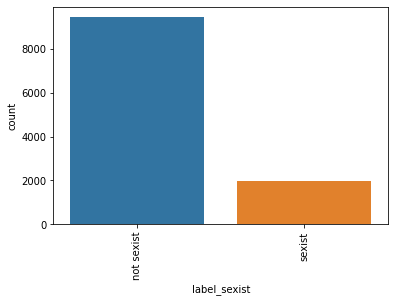

In [13]:
def count_plot(df, name, key_count = key_for_task):
    print(df.info())
    sn.countplot(data=df, x=key_count)
    plt.xticks(rotation = 90)
    plt.savefig(name)
    plt.show()
    
count_plot(df,"distribution.svg")

In [14]:
# df_reddit_aug = pd.read_csv('/kaggle/input/edosprivateinference/augmented-label-reddit_1M_unlabelled.csv',delimiter=',',encoding='utf-8')
# df_reddit_aug = df_reddit_aug[df_reddit_aug['label_pred']=='sexist']
# df_reddit_aug = df_reddit_aug.head(6000) # (10k - 3k) around 6k
# df_reddit_aug = df_reddit_aug.rename({'label_pred':key_for_task}, axis=1)

# count_plot(df_reddit_aug,"distribution-reddit-augmention.svg")

In [15]:
# df = pd.concat([df, df_reddit_aug], ignore_index=True)

# count_plot(df,"distribution-final.svg")

In [16]:
# df_sexist_only_para = pd.read_csv('/kaggle/input/edosprivateinference/augmented-paraphrase.csv',delimiter=',',encoding='utf-8')

# df = pd.concat([df, df_sexist_only_para], ignore_index=True)

# count_plot(df,"distribution-final-w-para.svg")

In [17]:
# df_call_me = pd.read_csv('/kaggle/input/call-me-sexist-but/sexism_data.csv',delimiter=',',encoding='utf-8')

# df_call_me.drop(['id', 'dataset', 'toxicity', 'of_id'],axis=1,inplace=True)
# df_call_me = df_call_me.rename({'sexist':'label_sexist'}, axis=1)
# df_call_me = df_call_me.replace({False: 'not sexist', True: 'sexist'})
# df_call_me = df_call_me[df_call_me['label_sexist']=='sexist']

# # df_call_me.head()

# count_plot(df_call_me,"distribution-callme.svg")

In [18]:
# df = pd.concat([df, df_call_me], ignore_index=True)

# count_plot(df,"distribution--w--callme.svg")

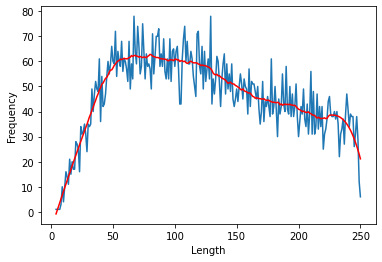

In [19]:
lens = df.text.str.len().value_counts()
count_plot = pd.DataFrame({'leng':lens.index, 'freq':lens.values}).sort_values('leng')
plt.plot(count_plot.leng,count_plot.freq)
plt.plot(count_plot.leng,savgol_filter(count_plot.freq, 51, 3), color='red')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [20]:
label_encoder = LabelEncoder()

# label encoding

X = df['text']
Y = df[key_for_task]
Y = label_encoder.fit_transform(Y)

In [21]:
label_encoder_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_encoder_mapping)
inverse_label_encoder_mapping = {label_encoder_mapping[k]:k for k in label_encoder_mapping}
print(inverse_label_encoder_mapping)
NUM_CLASS = len(label_encoder_mapping)

{'not sexist': 0, 'sexist': 1}
{0: 'not sexist', 1: 'sexist'}


In [22]:
# one hot encoding

Y = tf.keras.utils.to_categorical(Y, num_classes=NUM_CLASS)

In [23]:
DEBUG_EPOCH = 20 # keep it 2, just to test notebook, before saving

EPOCH = DEBUG_EPOCH if is_interactive() else 180
print(EPOCH)

20


In [24]:
# "sentence-transformers/all-MiniLM-L6-v2" <--- this one is the killer
## https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

class Sentence2Sentence(Layer):
    def __init__(self, **kwargs):
        super(Sentence2Sentence, self).__init__(**kwargs)

        pre_name = "sentence-transformers/all-MiniLM-L6-v2"
        self.tokenizer = AutoTokenizer.from_pretrained(pre_name)
        self.model = TFAutoModel.from_pretrained(pre_name)

        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x[0].decode('utf-8') for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return (outputs['input_ids'], outputs['token_type_ids'], outputs['attention_mask'])

        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32, tf.int32])

    def process(self,i,t,a):

        def __call(i, t, a):
            model_output = self.model({'input_ids': i.numpy(),'token_type_ids': t.numpy(),'attention_mask': a.numpy()})
            return model_output[0]

        return tf.py_function(func=__call, inp=[i, t, a], Tout=[tf.float32])

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = tf.squeeze(tf.stack(model_output), axis=0)
        input_mask_expanded = tf.cast(tf.broadcast_to(tf.expand_dims(attention_mask, -1),tf.shape(token_embeddings)), tf.float32)
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        (embeddings, _) = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings

    def call(self, inputs):
        (input_ids, token_type_ids, attention_mask) = self.tf_encode(inputs)
        input_ids.set_shape(tf.TensorShape((None, None)))
        token_type_ids.set_shape(tf.TensorShape((None, None)))
        attention_mask.set_shape(tf.TensorShape((None, None)))

        model_output = self.process(input_ids, token_type_ids,attention_mask)
        
        model_output[0].set_shape(tf.TensorShape((None, None, 384)))
        embeddings = self.mean_pooling(model_output, attention_mask)
        return embeddings

In [25]:
# "distilbert-base-uncased"
## https://huggingface.co/distilbert-base-uncased

class BertDistil(Layer):
    def __init__(self, **kwargs):
        super(BertDistil, self).__init__(**kwargs)

        pre_name = "distilbert-base-uncased"
        self.tokenizer = AutoTokenizer.from_pretrained(pre_name)
        self.model = TFAutoModel.from_pretrained(pre_name)

        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x[0].decode('utf-8') for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return (outputs['input_ids'], outputs['attention_mask'])

        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32])

    def process(self,i,a):

        def __call(i, a):
            model_output = self.model({'input_ids': i.numpy(), 'attention_mask': a.numpy()})
            return model_output[0]

        return tf.py_function(func=__call, inp=[i, a], Tout=[tf.float32])

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = tf.squeeze(tf.stack(model_output), axis=0)
        input_mask_expanded = tf.cast(tf.broadcast_to(tf.expand_dims(attention_mask, -1),tf.shape(token_embeddings)), tf.float32)
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        (embeddings, _) = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings

    def call(self, inputs):
        (input_ids, attention_mask) = self.tf_encode(inputs)
        input_ids.set_shape(tf.TensorShape((None, None)))
        attention_mask.set_shape(tf.TensorShape((None, None)))

        model_output = self.process(input_ids,attention_mask)
        
        model_output[0].set_shape(tf.TensorShape((None, None, 768)))
        embeddings = self.mean_pooling(model_output, attention_mask)
        return embeddings

In [26]:
from tensorflow.keras.layers import Layer

from transformers import ElectraTokenizer, TFElectraModel


class ElectraSmall(Layer):
    def __init__(self, **kwargs):
        super(ElectraSmall, self).__init__(**kwargs)

        pre_name = "google/electra-small-generator"
        self.tokenizer = AutoTokenizer.from_pretrained(pre_name)
        self.model = TFAutoModel.from_pretrained(pre_name)

    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x[0].decode('utf-8') for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return (outputs['input_ids'], outputs['attention_mask'])

        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32])

    def process(self,i,a):
        def __call(i, a):
            model_output = self.model({'input_ids': i.numpy(), 'attention_mask': a.numpy()})
            return model_output[0]

        return tf.py_function(func=__call, inp=[i, a], Tout=[tf.float32])

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = tf.squeeze(tf.stack(model_output), axis=0)
        input_mask_expanded = tf.cast(tf.broadcast_to(tf.expand_dims(attention_mask, -1),tf.shape(token_embeddings)), tf.float32)
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        (embeddings, _) = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings

    def call(self, inputs):
        (input_ids, attention_mask) = self.tf_encode(inputs)
        input_ids.set_shape(tf.TensorShape((None, None)))
        attention_mask.set_shape(tf.TensorShape((None, None)))

        model_output = self.process(input_ids, attention_mask)

        model_output[0].set_shape(tf.TensorShape((None, None, 256)))
        embeddings = self.mean_pooling(model_output, attention_mask)
        return embeddings


In [27]:
class StringLowerLayer(Layer):
    def __init__(self, **kwargs):
        super(StringLowerLayer, self).__init__(**kwargs)
        
    def call(self, inputs):
        return tf.strings.lower(inputs)

In [28]:
# to put more emphasize on words, like:
## 'us' -> it may help us for vectorized classification
## (naughty / slang) keywords -> may help us detect at binary level
### it will also help us to tune for "i love you, let's f^&*", tweet-bert will return it positive, but it should be negative
## characters -> it may indicate that there was something that the writer intentionally hide, knowingly it was questionable


class StressLayer(Layer):
    def __init__(self, **kwargs):
        super(StressLayer, self).__init__(**kwargs)

In [29]:
def get_model():
    text_input = Input(shape=(1,), dtype=tf.string,)
    
    
    
    x = Sentence2Sentence()(text_input)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(NUM_CLASS, activation='sigmoid')(x)
    
    
    
    y = ElectraSmall()(text_input)
    y = Dropout(0.5)(y)
    y = Dense(512, activation='relu')(y)
    y = Dropout(0.5)(y)
    y = Dense(256, activation='relu')(y)
    y = Dropout(0.5)(y)
    y = Dense(64, activation='relu')(y)
    y = Dense(NUM_CLASS, activation='sigmoid')(y)
    
    
    x = Add()([x,y])
    

    model = Model(inputs=[text_input], outputs = [x])
    return model

In [30]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2

In [31]:
with strategy.scope():
    model = get_model()
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(
        loss=CategoricalCrossentropy(from_logits=True),
        optimizer=optimizer,
        metrics=[
            F1Score(num_classes=NUM_CLASS,average='macro'),
        ],
    )

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.8M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Some layers from the model checkpoint at google/electra-small-generator were not used when initializing TFElectraModel: ['generator_lm_head', 'generator_predictions', 'activation']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-small-generator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
electra_small (ElectraSmall)    (None, 256)          13483008    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_58 (Dropout)            (None, 256)          0           electra_small[0][0]              
__________________________________________________________________________________________________
sentence2_sentence (Sentence2Se (None, 384)          22713216    input_1[0][0]                    
______________________________________________________________________________________________

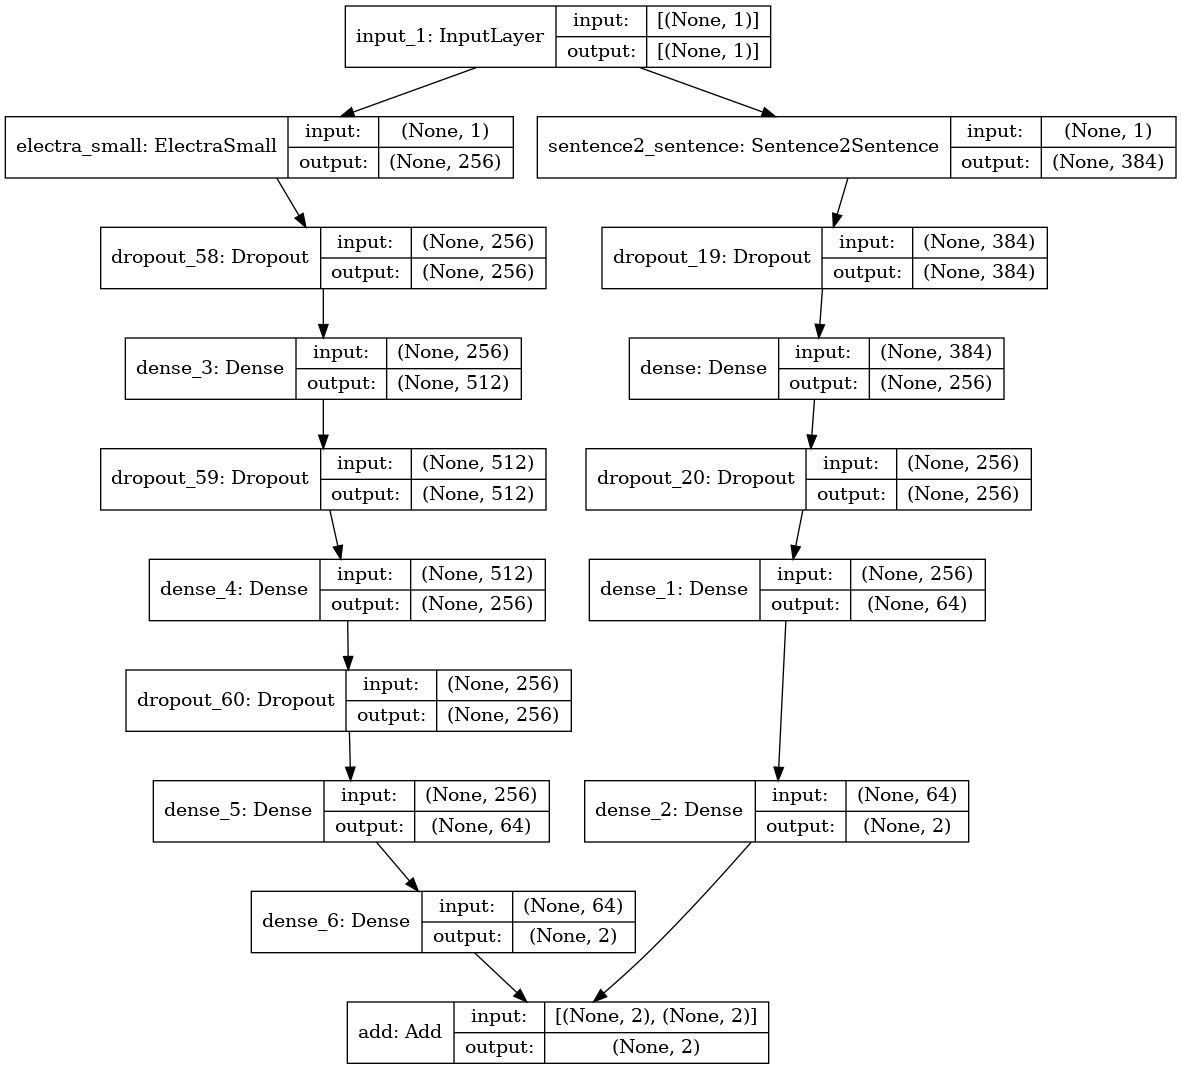

In [33]:
tf.keras.utils.plot_model(model, to_file='model.png',expand_nested=True,show_shapes=True,dpi=None,)

In [34]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=10)
early_stopping_callback = EarlyStopping(monitor='val_loss',min_delta=0,patience=30,verbose=0, mode='auto')
model_saver = ModelCheckpoint(filepath='model.h5', save_best_only=True)

callbacks = [early_stopping_callback, lr_reducer,model_saver]

In [35]:
SHUFFLE_DS = 1024
BATCH_SIZE_DS = 16 * strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE

if task == 'a':
    train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.3, stratify=Y)
else:
    train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.3)


# train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).repeat().shuffle(SHUFFLE_DS).batch(BATCH_SIZE_DS).prefetch(AUTO)
# val_ds = tf.data.Dataset.from_tensor_slices((val_X, val_Y)).repeat().shuffle(SHUFFLE_DS).batch(BATCH_SIZE_DS).prefetch(AUTO)
    
N_STEPS = len(train_X) / BATCH_SIZE_DS

In [36]:
history_model = model.fit(train_X, train_Y,epochs=EPOCH,validation_data=(val_X, val_Y), callbacks=callbacks, steps_per_epoch = N_STEPS)

Epoch 1/20
498/498 [==============================] - 124s 246ms/step - loss: 0.5420 - f1_score: 0.4717 - val_loss: 0.4658 - val_f1_score: 0.4529


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
498/498 [==============================] - 120s 241ms/step - loss: 0.4556 - f1_score: 0.4529 - val_loss: 0.4444 - val_f1_score: 0.4529
Epoch 3/20
498/498 [==============================] - 119s 239ms/step - loss: 0.4379 - f1_score: 0.4529 - val_loss: 0.4241 - val_f1_score: 0.4529
Epoch 4/20
498/498 [==============================] - 118s 238ms/step - loss: 0.4176 - f1_score: 0.4529 - val_loss: 0.3969 - val_f1_score: 0.4529
Epoch 5/20
498/498 [==============================] - 118s 236ms/step - loss: 0.3889 - f1_score: 0.4529 - val_loss: 0.3678 - val_f1_score: 0.4529
Epoch 6/20
498/498 [==============================] - 117s 236ms/step - loss: 0.3674 - f1_score: 0.4529 - val_loss: 0.3464 - val_f1_score: 0.4529
Epoch 7/20
498/498 [==============================] - 117s 235ms/step - loss: 0.3525 - f1_score: 0.4529 - val_loss: 0.3321 - val_f1_score: 0.4529
Epoch 8/20
498/498 [==============================] - 116s 232ms/step - loss: 0.3430 - f1_score: 0.4529 - val_loss: 0.3244 -

In [37]:
!mkdir history

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [38]:
with open('history/history.json','w') as f:
    f.write(str(history_model.history))

In [39]:
!mkdir figures

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


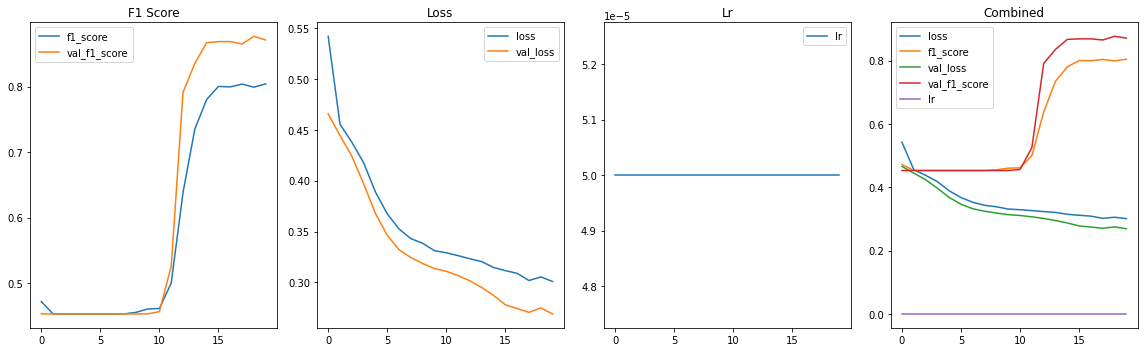

In [40]:
def captilize(string):
    string = string.replace("_"," ")
    return string.title()
    
    
def plot_graphs(data, keys):
    fig, axes = plt.subplots(1, (len(keys) + 1) , figsize=(16, 5))
    plt.legend(loc='best')
    
    for i in range(len(keys)):
        df_graph = pd.DataFrame({x:data[x] for x in data if keys[i] in x})
        df_keys = [x for x in data if keys[i] in x]
        df_graph[df_keys].plot(ax=axes[i])
        axes[i].set_title(captilize(keys[i]))
        
    last_index = len(keys)
    all_keys = [x for x in data if x]
    
    df_combined = pd.DataFrame({x: data[x] for x in data})
    df_combined[all_keys].plot(ax=axes[last_index])
    axes[len(keys)].set_title('Combined')
    
    plt.tight_layout()
    
    plt.savefig('figures/figure_optimizer.svg')
    plt.show()
        
plot_graphs(data = history_model.history, keys= ['f1_score','loss', 'lr'])

In [41]:
def process_and_save_result(problem_name):
    df_test = pd.read_csv("/kaggle/input/explainable-detection-of-online-sexism-edos/public_data__"+problem_name+"/dev_task_"+problem_name+"_entries.csv",delimiter=',',encoding='utf-8')
    test_texts = df_test['text']

    predictions = model.predict(test_texts)
    
    results=pd.DataFrame({"rewire_id":df_test['rewire_id'],"label_pred": [inverse_label_encoder_mapping[np.argmax(x)] for x in predictions]})
    results.dropna()
    results = results[results['label_pred']!='none']
    
    results.to_csv("submission-"+problem_name+".csv",index=False)
    results.head()

In [42]:
process_and_save_result(task)

In [43]:
!zip submizzion-a.zip submission-a.csv
# !zip submizzion-b.zip submission-b.csv
# !zip submizzion-c.zip submission-c.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: submission-a.csv (deflated 90%)


In [44]:
# !pip install shap

In [45]:
# import shap

# background = np.random.choice(train_X.shape[0], 100, replace=False)

# # explain predictions of the model on four images
# e = shap.DeepExplainer(model, background)
# # ...or pass tensors directly
# # e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
# shap_values = e.shap_values(val_X[1:5])

# # plot the feature attributions
# shap.image_plot(shap_values, -val_X[1:5])